# Unlocking Box Office Success: Predicting Movie Popularity

UCB Data Analytics Bootcamp: Project 4

Group 6: Gursimran Kaur (Simran), Jeff Kim, and Rose Mary Rios

# Project Overview
This project illustrates our team's learning and proficiency of an extensive set of tools and methodologies, effectively applied to accomplish objectives throughout the processes of ETL, Exploratory Data Analysis (EDA), and the exploration and optimization of machine learning models.

### Objective 
This project aims to develop Linear Regression and Random Forest models to predict a movie's popularity score based on features like budget, runtime, genre, and user ratings. 
Our goal is to enable stakeholders in the movie industry to estimate a film's potential popularity before its release. By analyzing historical movie data, our predictive models will identify key attributes that influence success, providing producers and marketers with valuable insights.

### Methods Used
This structured approach includes data cleaning, feature engineering, model selection, evaluation, and iterative optimization, demonstrating a full-spectrum understanding of the data analytics and machine learning workflow: 
- ETL (Extract, Transform, Load): Prepare the data by extracting it from sources, transforming it for analysis, and loading it into a structured format.
- EDA (Exploratory Data Analysis): Analyze the dataset to understand its structure, patterns, and potential insights.
- Model Selection: Choose an appropriate machine learning model based on the problem and dataset characteristics.
- Baseline Model Performance: Train the initial model and evaluate its performance using baseline metrics.
- Performant Model Comparison: Experiment with other an alternative model to compare their performance against the baseline.
- Identify Best-Performing Model: Select the model that achieves the best results based on accuracy, precision, or other metrics.
- Iterative Optimization Processing: Fine-tune the best model to improve its performance, aiming to meet or exceed a specific performance threshold, such as 75% accuracy. 

### Data Sources
- [TMDB 5000 Movie Dataset (movives & credits)](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)
- [Oscar Best Picture Movies](https://www.kaggle.com/datasets/martinmraz07/oscar-movies)

In [1]:
# Import required dependencies 
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso

# Extract, Transform, & Load (ETL) 

In this section, we will work through the process of reading in three data sources* in CSV format, parsing out necessary data elements , performing feature engineering, and cleaning the data. 

Finally, we will create new DataFrames from specific columns and merge them based on a common key, `movie_id`.



### Loading and Reading the "MOVIES" Data 

In [2]:
# Read the "movie" dataset CSV file
df1 = pd.read_csv('data/tmdb_5000_movies.csv')

# Print the first few rows of each DataFrame
print("DataFrame 1:")
print(df1.head())


DataFrame 1:
      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"i

#### Dropping Unnecessary Columns  

In [3]:
# Drop the specified columns
movie_metadata_df = df1.drop(columns=['homepage', 'original_title', 'overview', 'spoken_languages'])

#### Mapping Movie Languages to Full Names

We decided to create a new mapping DataFrame that links the language acronyms (e.g., `fr` for French) to their full language names. This mapping is then merged with the main DataFrame based on the `original_language` column. This step provides a clearer understanding of the movie's original language acronyumn and full name, improving readability and interpretation.

In [4]:
# Create a mapping DataFrame for languages movie were created in for acronymn and full name 
language_mapping_df = pd.DataFrame({
    'language': ['en', 'de', 'es', 'zh', 'ja', 'fr', 'da', 'it', 'sv', 'hi',
                 'ru', 'pt', 'ko', 'af', 'ro', 'nl', 'ar', 'he', 'th', 'cn',
                 'tr', 'cs', 'fa', 'no', 'ps', 'vi', 'el', 'hu', 'nb', 'xx',
                 'id', 'pl', 'is', 'te', 'ta', 'ky', 'sl'],
    'full_original_name': ['English', 'German', 'Spanish', 'Chinese', 'Japanese', 'French',
                           'Danish', 'Italian', 'Swedish', 'Hindi', 'Russian', 'Portuguese',
                           'Korean', 'Afrikaans', 'Romanian', 'Dutch', 'Arabic', 'Hebrew',
                           'Thai', 'Chinese', 'Turkish', 'Czech', 'Persian', 'Norwegian',
                           'Pashto', 'Vietnamese', 'Greek', 'Hungarian', 'Norwegian Bokmål',
                           'Unknown', 'Indonesian', 'Polish', 'Icelandic', 'Telugu', 
                           'Tamil', 'Kyrgyz', 'Slovenian']
})

# Merge the mapping DataFrame with your existing DataFrame
movie_metadata_df = movie_metadata_df.merge(
    language_mapping_df,
    left_on='original_language',  # Column with the language acronym
    right_on='language',          # Column in the mapping DataFrame
    how='left'
)

# Display the updated DataFrame, including the new column
print(movie_metadata_df[['original_language', 'full_original_name']])


     original_language full_original_name
0                   en            English
1                   en            English
2                   en            English
3                   en            English
4                   en            English
...                ...                ...
4798                es            Spanish
4799                en            English
4800                en            English
4801                en            English
4802                en            English

[4803 rows x 2 columns]


#### Parsing the First Production Country

By utilizing a custom function to parse the JSON-formatted `production_countries` column, we were able to extract the ISO code and full name of the first listed country. This helps us identify the primary country associated with the movie's production and availability visualizations ( if needed).

In [5]:
# Function to parse the first movie production country

def parse_first_country(row):
    try:
        # Load the JSON string from the 'production_countries' column
        countries = json.loads(row['production_countries'])
        if countries:
            # Extract the first country's iso_3166_1 and name
            return countries[0]['iso_3166_1'], countries[0]['name']
        else:
            return None, None
    except (json.JSONDecodeError, IndexError):
        return None, None

# Apply the function to the DataFrame and create new columns
movie_metadata_df[['iso_3166_1', 'country_name']] = movie_metadata_df.apply(parse_first_country, axis=1, result_type='expand')

# Display the values only (without labels)
for index, row in movie_metadata_df.iterrows():
    iso_code = row['iso_3166_1']
    country = row['country_name']
    if iso_code and country:  # Only print if both values are present
        print(f"{iso_code}, {country}")


US, United States of America
US, United States of America
GB, United Kingdom
US, United States of America
US, United States of America
US, United States of America
US, United States of America
US, United States of America
GB, United Kingdom
US, United States of America
US, United States of America
GB, United Kingdom
JM, Jamaica
US, United States of America
GB, United Kingdom
CZ, Czech Republic
US, United States of America
US, United States of America
US, United States of America
NZ, New Zealand
US, United States of America
GB, United Kingdom
NZ, New Zealand
GB, United Kingdom
NZ, New Zealand
US, United States of America
US, United States of America
US, United States of America
US, United States of America
GB, United Kingdom
US, United States of America
CN, China
US, United States of America
CA, Canada
US, United States of America
US, United States of America
US, United States of America
US, United States of America
US, United States of America
US, United States of America
US, United St

#### Converting Release Date and Extracting Seasons
For analysis purpose, we converted the `release_date` column to a proper datetime format to ensure consistency. 
A new feature was created, `release_date_season`, to determine the season (Winter, Spring, Summer, or Fall) in which each movie was released. This new feature may aid with identifing patterns in movie releases based on the time of year.

In [6]:
# Convert the 'release_date' column to datetime
movie_metadata_df['release_date'] = pd.to_datetime(movie_metadata_df['release_date'])

# Function to determine the season for a given movie release date
def get_season(date):
    if pd.isna(date):  # Check if the date is NaT
        return None

    # Determine the season based on the month
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'
    else:
        return None

# Apply the function to create a new column for the season
movie_metadata_df['release_date_season'] = movie_metadata_df['release_date'].apply(get_season)

# Display the updated DataFrame with the season results
print(movie_metadata_df[['title', 'release_date', 'release_date_season']])

# For debugging, also print the full DataFrame if needed
print("\nFull DataFrame for reference:")
print(movie_metadata_df[['title', 'release_date', 'release_date_season']])


                                         title release_date  \
0                                       Avatar   2009-12-10   
1     Pirates of the Caribbean: At World's End   2007-05-19   
2                                      Spectre   2015-10-26   
3                        The Dark Knight Rises   2012-07-16   
4                                  John Carter   2012-03-07   
...                                        ...          ...   
4798                               El Mariachi   1992-09-04   
4799                                 Newlyweds   2011-12-26   
4800                 Signed, Sealed, Delivered   2013-10-13   
4801                          Shanghai Calling   2012-05-03   
4802                         My Date with Drew   2005-08-05   

     release_date_season  
0                 Winter  
1                 Spring  
2                   Fall  
3                 Summer  
4                 Spring  
...                  ...  
4798                Fall  
4799              Winter  


#### Formatting Budget, Revenue, Vote Count, and Popularity
Numerical columns will be formatted for improved readability.
- `budget` and `revenue` are formatted as currency.
- `vote_count` is converted to thousands (K) format.
- `popularity` is rounded to one decimal point to maintain consistency.
- Filter the dataset where status = ```Released``` and drop other irrelevant status rows such as ```Canceled```. 

In [7]:
# Format the 'budget' and 'revenue' fields as currency using string formatting
movie_metadata_df['budget'] = movie_metadata_df['budget'].apply(lambda x: f"${x:,.0f}" if pd.notnull(x) else x)
movie_metadata_df['revenue'] = movie_metadata_df['revenue'].apply(lambda x: f"${x:,.0f}" if pd.notnull(x) else x)

# Format the 'vote_count' field to thousands (K) format
movie_metadata_df['vote_count'] = movie_metadata_df['vote_count'].apply(lambda x: f"{x/1000:.1f}K" if pd.notnull(x) else x)

# Format the 'popularity' field to one decimal point
movie_metadata_df['popularity'] = movie_metadata_df['popularity'].apply(lambda x: f"{x:.1f}" if pd.notnull(x) else x)

# Filter the DataFrame where 'status' is 'Released' and keep the name 'movie_metadata_df'
movie_metadata_df = movie_metadata_df[movie_metadata_df['status'] == 'Released']

#### Parsing and Filtering Data

The `genres`, `keywords`, and `production_company` columns in the original dataset contained lengthy and difficult-to-read strings. To make the data more manageable, we extracted the `ID` and `Name` from these columns and created three separate DataFrames : genres_list , keywords_list and companies_list.  

 This allowed us to clean the data more effectively, and by using `movie_ID` as the primary key, we could later join these DataFrames back together into one cohesive dataset.

Partsing these columns allows us to work with individual elements, manageable data provides cleaner, more structured, and actionable data that supports deeper insights and more effective analysis and machine learning models require structured, non-nested data.

In [8]:
# Get column names as a list
columns_list = movie_metadata_df.columns.tolist()
print(columns_list)

['budget', 'genres', 'id', 'keywords', 'original_language', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title', 'vote_average', 'vote_count', 'language', 'full_original_name', 'iso_3166_1', 'country_name', 'release_date_season']


In [9]:
# Function to parse the 'genres' column and create separate rows for each genre
def parse_genres(row):
    try:
        # Parse the JSON string from the 'genres' column
        genres = json.loads(row['genres'])
        # Create a list of tuples (movie_id, genre_id, genre_name)
        return [(row['id'], genre['id'], genre['name']) for genre in genres]
    except json.JSONDecodeError:
        return []

# Function to parse the 'keywords' column and create separate rows for each keyword
def parse_keywords(row):
    try:
        # Parse the JSON string from the 'keywords' column
        keywords = json.loads(row['keywords'])
        # Create a list of tuples (movie_id, keyword_id, keyword_name)
        return [(row['id'], keyword['id'], keyword['name']) for keyword in keywords]
    except json.JSONDecodeError:
        return []

# Function to parse the 'production_companies' column and create separate rows for each company
def parse_production_companies(row):
    try:
        # Parse the JSON string from the 'production_companies' column
        companies = json.loads(row['production_companies'])
        # Create a list of tuples (movie_id, company_id, company_name)
        return [(row['id'], company['id'], company['name']) for company in companies]
    except json.JSONDecodeError:
        return []

# Apply the parsing functions to the 'genres', 'keywords', and 'production_companies' columns
genres_list = movie_metadata_df.apply(parse_genres, axis=1).explode()
keywords_list = movie_metadata_df.apply(parse_keywords, axis=1).explode()
companies_list = movie_metadata_df.apply(parse_production_companies, axis=1).explode()

# Create new DataFrames from the parsed lists
genre_df = pd.DataFrame(genres_list.tolist(), columns=['movie_id', 'genre_id', 'genre_name'])
keyword_df = pd.DataFrame(keywords_list.tolist(), columns=['movie_id', 'keyword_id', 'keyword_name'])
production_company_df = pd.DataFrame(companies_list.tolist(), columns=['movie_id', 'company_id', 'company_name'])

# Drop any rows with missing data (in case of malformed or missing information)
genre_df.dropna(inplace=True)
keyword_df.dropna(inplace=True)
production_company_df.dropna(inplace=True)

# Display the first few rows of the new DataFrames
print("Genres DataFrame:")
print(genre_df.head())

print("\nKeywords DataFrame:")
print(keyword_df.head())

print("\nProduction Companies DataFrame:")
print(production_company_df.head())

print("Movie Metadata DataFrame:")
print(movie_metadata_df.head())

Genres DataFrame:
   movie_id  genre_id       genre_name
0   19995.0      28.0           Action
1   19995.0      12.0        Adventure
2   19995.0      14.0          Fantasy
3   19995.0     878.0  Science Fiction
4     285.0      12.0        Adventure

Keywords DataFrame:
   movie_id  keyword_id   keyword_name
0   19995.0      1463.0  culture clash
1   19995.0      2964.0         future
2   19995.0      3386.0      space war
3   19995.0      3388.0   space colony
4   19995.0      3679.0        society

Production Companies DataFrame:
   movie_id  company_id                            company_name
0   19995.0       289.0                 Ingenious Film Partners
1   19995.0       306.0  Twentieth Century Fox Film Corporation
2   19995.0       444.0                      Dune Entertainment
3   19995.0       574.0                Lightstorm Entertainment
4     285.0         2.0                    Walt Disney Pictures
Movie Metadata DataFrame:
         budget                                   

In [10]:
# Drop the fields that have been parsed out to new DataFrames (genres, keywords, production_companies)
movie_metadata_df = movie_metadata_df.drop(columns=['genres', 'keywords', 'production_companies'])

#### Aggregating Genres, Keywords, and Production Companies by Movie ID 

- Group the `genre_df` by `movie_id` and aggregate the genres into a single string for each movie. 
- Group the `keyword_df` by `movie_id` and aggregate all keywords into one string per movie.
- Group the `production_company_df` by `movie_id` and aggregate the production companies into one string per movie. 

This simplifies the data by storing the values into single columns, reducing complexity.

#### Merging Aggregated DataFrames

We merged the aggregated `genres` DataFrame with the `keywords` DataFrame. Then, merged the result with the `production_companies` DataFrame, creating a unified DataFrame with all movie information in one place.

In [11]:
# Aggregate genres by movie_id
genre_df_agg = genre_df.groupby('movie_id')['genre_name'].apply(lambda x: ', '.join(x)).reset_index()

# Aggregate keywords by movie_id
keyword_df_agg = keyword_df.groupby('movie_id')['keyword_name'].apply(lambda x: ', '.join(x)).reset_index()

# Aggregate production companies by movie_id
production_company_df_agg = production_company_df.groupby('movie_id')['company_name'].apply(lambda x: ', '.join(x)).reset_index()

# Merge the three DataFrames with each other
# First merge genres with keywords
unique_movie_record_df = pd.merge(genre_df_agg, keyword_df_agg, on='movie_id', how='outer')

# Second merge the result with production companies
unique_movie_record_df = pd.merge(unique_movie_record_df, production_company_df_agg, on='movie_id', how='outer')

# Display the merged DataFrame
unique_movie_record_df.head(5)


,movie_id,genre_name,keyword_name,company_name
0,5.0,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart"
1,11.0,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation"
2,12.0,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios
3,13.0,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures
4,14.0,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company"


### Loading and Reading the "OCARS Data

This secondary dataset provides critical context regarding movie awards, genres and their ratings, supporting predictive modeling efforts with data from thew following groupings : Film Details, Production Information, Awards, Genre and Ratings, Critic data.

By incorporating this dataset, we aim to analyze the impact of awards on movie popularity scores. 

In [12]:
# Define the file path based on your working directory
file_path = 'data/oscars_df.csv'

# Load the Oscar CSV file into a new DataFrame
oscars_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(oscars_df.head())

   Unnamed: 0                 Film Oscar Year Film Studio/Producer(s)  \
0           0                Wings    1927/28    Famous Players-Lasky   
1           1           7th Heaven    1927/28                     Fox   
2           2           The Racket    1927/28       The Caddo Company   
3           3  The Broadway Melody    1928/29     Metro-Goldwyn-Mayer   
4           4                Alibi    1928/29     Feature Productions   

     Award  Year of Release  Movie Time            Movie Genre  IMDB Rating  \
0   Winner             1927         144      Drama,Romance,War          7.5   
1  Nominee             1927         110          Drama,Romance          7.7   
2  Nominee             1928          84  Crime,Drama,Film-Noir          6.7   
3   Winner             1929         100  Drama,Musical,Romance          5.7   
4  Nominee             1929          91   Action,Crime,Romance          5.8   

  IMDB Votes  ... Tomatometer Status Tomatometer Rating Tomatometer Count  \
0     12,

#### Merging Oscar Data with Movie Metadata

Merged the `oscars_df` with the main `movie_metadata_df` and adding the `award` column to the merged dataframe.

In [13]:
# Perform the merge/join operation, matching 'Film' column from oscar_df with 'title' column from movie_metadata_df
# Only the 'award' column from oscar_df will be added to movie_metadata_df
movie_metadata_df = movie_metadata_df.merge(oscars_df[['Film', 'Oscar Year', 'Year of Release', 'Award']], 
                                            how='left', 
                                            left_on='title', 
                                            right_on='Film')

# Drop the 'Film' column from the merge (since it's the same as 'title')
movie_metadata_df = movie_metadata_df.drop(columns=['Film'])

# Ensure 'award' is the last column
award_column = movie_metadata_df.pop('Award')
movie_metadata_df['Award'] = award_column

# Display the first few rows of the updated DataFrame
print(movie_metadata_df.head())

         budget      id original_language popularity  \
0  $237,000,000   19995                en      150.4   
1  $300,000,000     285                en      139.1   
2  $245,000,000  206647                en      107.4   
3  $250,000,000   49026                en      112.3   
4  $260,000,000   49529                en       43.9   

                                production_countries release_date  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   
3  [{"iso_3166_1": "US", "name": "United States o...   2012-07-16   
4  [{"iso_3166_1": "US", "name": "United States o...   2012-03-07   

          revenue  runtime    status  \
0  $2,787,965,087    162.0  Released   
1    $961,000,000    169.0  Released   
2    $880,674,609    148.0  Released   
3  $1,084,939,099    165.0  Released   
4    $284,139,100    132.0  Released   

       

### Loading, Reading, and Parsing "CREDITS" Data

Data source is too large to download into an Excel. Team gained guidance from TA to most effiently import all data was to change file into a "parquet" file, which would enable file to import all data and enable it to be read like a csv file. 

Loaded the `credits_5000.parquet` file and extracted the first cast member and director for each movie. 

- **Cast**: We pulled the first actor's `ID` and `name` from the `cast` column.
- **Crew**: We extracted the director's `ID` and `name` from the `crew` column.
- Both are combined into a new DataFrame along with the `movie_id` and `title`.
- Remove any rows with missing data to keep the dataset clean.

In [14]:
# Load the parquet file 
file_path = 'data/credits_5000.parquet'
credits_df = pd.read_parquet(file_path)

# Check if the 'crew' column exists
if 'crew' not in credits_df.columns or 'cast' not in credits_df.columns:
    raise KeyError("The required columns 'crew' or 'cast' are missing from the DataFrame.")

# Function to parse the 'cast' column and extract only the first 'id' and 'name'
def parse_first_cast(row):
    try:
        # Parse the JSON string from the 'cast' column
        cast_list = json.loads(row['cast'])
        if cast_list:
            # Return the first cast member's id and name
            return (row['movie_id'], row['title'], cast_list[0]['id'], cast_list[0]['name'])
        else:
            return (row['movie_id'], row['title'], None, None)
    except (json.JSONDecodeError, IndexError):
        return (row['movie_id'], row['title'], None, None)

# Function to parse the 'crew' column and extract only the first 'id' and 'name'
def parse_first_crew(row): 
    try:
        # Parse the JSON string from the 'crew' column
        crew_list = json.loads(row['crew'])
        if crew_list:
            # Return the first crew member with the job 'Director'
            director = next((member for member in crew_list if member['job'] == 'Director'), None)
            if director:  # Check if a director was found
                return (row['movie_id'], row['title'], director['id'], director['name'])
            else:
                return (row['movie_id'], row['title'], None, None)
        else: 
            return (row['movie_id'], row['title'], None, None)
    except (json.JSONDecodeError, IndexError): 
        return (row['movie_id'], row['title'], None, None)

# Apply the parsing functions to extract only the first cast and crew members
cast_info = credits_df.apply(parse_first_cast, axis=1)
crew_info = credits_df.apply(parse_first_crew, axis=1)

# Create separate DataFrames for cast and crew information
cast_df = pd.DataFrame(cast_info.tolist(), columns=['movie_id', 'title', 'cast_id', 'cast_name'])
crew_df = pd.DataFrame(crew_info.tolist(), columns=['movie_id', 'title', 'crew_id', 'crew_name'])

# Merge the cast and crew DataFrames on 'movie_id' and 'title'
cast_crew_merged_df = pd.merge(cast_df, crew_df, on=['movie_id', 'title'], how='outer')

# Drop any rows with missing data (if any) 
cast_crew_merged_df.dropna(inplace=True)

# Display the first few rows of the new DataFrame
print(cast_crew_merged_df.head())


   movie_id            title  cast_id      cast_name  crew_id        crew_name
0         5       Four Rooms   3129.0       Tim Roth   3110.0   Allison Anders
1        11        Star Wars      2.0    Mark Hamill      1.0     George Lucas
2        12     Finding Nemo     13.0  Albert Brooks      7.0   Andrew Stanton
3        13     Forrest Gump     31.0      Tom Hanks     24.0  Robert Zemeckis
4        14  American Beauty   1979.0   Kevin Spacey     39.0       Sam Mendes


#### Merging Movie Metadata Dataframe with Cast and Crew DataFrame

Merged the movie metadata dataframe (merged movie and oscar data) with the cast and crew dataframe using an outer join. This ensures that all records from both datasets are included.

- **Left Column**: We used the `id` from the `movie_metadata_df` to match movies.
- **Right Column**: We used the `movie_id` from the `cast_crew_merged_df`.
- **Outer Join**: We used an out join to inclusion of all data, even if there isn’t a matching value in the joining columns. Benfits : Retain all available data and  we can handle any missing values as needed for comprehensive analysis. 



In [15]:
# Merge the DataFrames on the specified columns using an outer join
# and store the result in the "merged_data" variable
merged_data = pd.merge(
    movie_metadata_df, 
    cast_crew_merged_df, 
    left_on='id',         # Column from movies_metadata_df
    right_on='movie_id',  # Column from cast_crew_merged_df
    how='outer'           # Outer join to include all data
)

# Display the merged DataFrame
merged_data.head(5) 


,budget,id,original_language,popularity,production_countries,release_date,revenue,runtime,status,tagline,...,release_date_season,Oscar Year,Year of Release,Award,movie_id,title_y,cast_id,cast_name,crew_id,crew_name
0,"$4,000,000",5.0,en,22.9,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-09,"$4,300,000",98.0,Released,Twelve outrageous guests. Four scandalous requ...,...,Winter,NaN,NaN,NaN,5.0,Four Rooms,3129.0,Tim Roth,3110.0,Allison Anders
1,"$11,000,000",11.0,en,126.4,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1977-05-25,"$775,398,007",121.0,Released,"A long time ago in a galaxy far, far away...",...,Spring,1977,1977.0,Nominee,11.0,Star Wars,2.0,Mark Hamill,1.0,George Lucas
2,"$94,000,000",12.0,en,85.7,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-05-30,"$940,335,536",100.0,Released,"There are 3.7 trillion fish in the ocean, they...",...,Spring,NaN,NaN,NaN,12.0,Finding Nemo,13.0,Albert Brooks,7.0,Andrew Stanton
3,"$55,000,000",13.0,en,138.1,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-07-06,"$677,945,399",142.0,Released,"The world will never be the same, once you've ...",...,Summer,1994,1994.0,Winner,13.0,Forrest Gump,31.0,Tom Hanks,24.0,Robert Zemeckis
4,"$15,000,000",14.0,en,80.9,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1999-09-15,"$356,296,601",122.0,Released,Look closer.,...,Fall,1999,1999.0,Winner,14.0,American Beauty,1979.0,Kevin Spacey,39.0,Sam Mendes


#### Merging Movie and Uniqie Movie Data and Saving the Result

Merged the combined credits DataFrame (merged_data) with the final version of the movie DataFrame (unique_movie_record_df), using an outer join to an updated version of "merged_data". 
- **Merge Columns**: We merged both DataFrames on the `movie_id` column.
- **Outer Join**: This ensures that no data is lost, including movies that might not have information in all datasets.
- The updated `merged_data` DataFrame is saved as a CSV file.

Note: At this point 'merged_data' is a fully cleaned dataframe from our 3 data sources of movie, oscar and credits data files. 

In [16]:
 # Merge the Unique DataFrames with the merged_data on the specified columns using an outer join
merged_data = pd.merge(
    merged_data, 
    unique_movie_record_df,
    left_on='movie_id',
    right_on='movie_id',  # Column from merged_df
    how='outer'           # Outer join to include all data
)
  
# Save the merged DataFrame to a CSV file
output_file_path = 'merged_data.csv'
merged_data.to_csv(output_file_path, index=False)

print(f"Merged DataFrame saved to {output_file_path}")


Merged DataFrame saved to merged_data.csv


In [17]:
# Print the merged DataFrame ( includes cleaned/eingineered movie & credit data)
print("Merged DataFrame:")
merged_data.head(5)


Merged DataFrame:


,budget,id,original_language,popularity,production_countries,release_date,revenue,runtime,status,tagline,...,Award,movie_id,title_y,cast_id,cast_name,crew_id,crew_name,genre_name,keyword_name,company_name
0,"$4,000,000",5.0,en,22.9,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-09,"$4,300,000",98.0,Released,Twelve outrageous guests. Four scandalous requ...,...,NaN,5.0,Four Rooms,3129.0,Tim Roth,3110.0,Allison Anders,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart"
1,"$11,000,000",11.0,en,126.4,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1977-05-25,"$775,398,007",121.0,Released,"A long time ago in a galaxy far, far away...",...,Nominee,11.0,Star Wars,2.0,Mark Hamill,1.0,George Lucas,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation"
2,"$94,000,000",12.0,en,85.7,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-05-30,"$940,335,536",100.0,Released,"There are 3.7 trillion fish in the ocean, they...",...,NaN,12.0,Finding Nemo,13.0,Albert Brooks,7.0,Andrew Stanton,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios
3,"$55,000,000",13.0,en,138.1,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-07-06,"$677,945,399",142.0,Released,"The world will never be the same, once you've ...",...,Winner,13.0,Forrest Gump,31.0,Tom Hanks,24.0,Robert Zemeckis,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures
4,"$15,000,000",14.0,en,80.9,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1999-09-15,"$356,296,601",122.0,Released,Look closer.,...,Winner,14.0,American Beauty,1979.0,Kevin Spacey,39.0,Sam Mendes,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company"


### Finalizing the Merged DataFrame

Finalize the dataset by performing several cleanup actions:

- **Dropping Duplicated Columns**: Remove columns that are no longer needed or duplicated.
   
- **Renaming Columns**: Rename several columns for clarity and consistency, such as `id` to `movie_id`, `title_x` to `movie_title` to make the dataset more understandable.

- **Handling Missing Values**: Replace `NaN` values in the `award` column with `Non-nominee`, and fill missing values in the `oscar_year` and `year_of_release` columns with `0` to ensure consistency and prevent any issues during analysis.

In [18]:
# Drop duplicated columns
final_movies_df = merged_data.drop(columns=['original_language', 'production_countries', 'movie_id', 'title_y'])

In [19]:
# Rename the columns 
final_movies_df = final_movies_df.rename(columns={'id': 'movie_id', 'title_x': 'movie_title', 'iso_3166_1': 'country_short', 'release_date_seasonholiday': 'release_date_season', 'Oscar Year': 'oscar_year', 'Year of Release': 'year_of_release', 'Award': 'award', 'cast_id': 'actor_id', 'cast_name': 'actor', 'crew_id': 'director_id', 'crew_name': 'director_name', 'genre_name': 'genres', 'keyword_name': 'keywords', 'company_name': 'production'})

# Replace NaN values in the 'award' column with 'Non-nominee'
final_movies_df['award'] = final_movies_df['award'].fillna('Non-nominee')

In [20]:
# Replace NaN values in 'oscar_year' and 'year_of_release' columns with 0
final_movies_df['oscar_year'] = final_movies_df['oscar_year'].fillna(0)
final_movies_df['year_of_release'] = final_movies_df['year_of_release'].fillna(0)

# Display the updated DataFrame
final_movies_df.head(5)

,budget,movie_id,popularity,release_date,revenue,runtime,status,tagline,movie_title,vote_average,...,oscar_year,year_of_release,award,actor_id,actor,director_id,director_name,genres,keywords,production
0,"$4,000,000",5.0,22.9,1995-12-09,"$4,300,000",98.0,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,...,0,0.0,Non-nominee,3129.0,Tim Roth,3110.0,Allison Anders,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart"
1,"$11,000,000",11.0,126.4,1977-05-25,"$775,398,007",121.0,Released,"A long time ago in a galaxy far, far away...",Star Wars,8.1,...,1977,1977.0,Nominee,2.0,Mark Hamill,1.0,George Lucas,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation"
2,"$94,000,000",12.0,85.7,2003-05-30,"$940,335,536",100.0,Released,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,...,0,0.0,Non-nominee,13.0,Albert Brooks,7.0,Andrew Stanton,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios
3,"$55,000,000",13.0,138.1,1994-07-06,"$677,945,399",142.0,Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,...,1994,1994.0,Winner,31.0,Tom Hanks,24.0,Robert Zemeckis,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures
4,"$15,000,000",14.0,80.9,1999-09-15,"$356,296,601",122.0,Released,Look closer.,American Beauty,7.9,...,1999,1999.0,Winner,1979.0,Kevin Spacey,39.0,Sam Mendes,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company"


#### Feature Engineering: Extracting Date Components

Performed feature engineering by extracting useful information from the `release_date` column:

- **Release Year**: Extract the year the movie was released and store it in the `release_year` column.
- **Release Month**: Extract the month of release and store it in the `release_month` column.
- **Day of the Week**: Extract the day of the week the movie was released and store it in the `release_dayofweek` column.
These new features can help identify trends or patterns related to movie release dates and timing.


In [21]:
# Feature Engineering - extracting year, month, and day from 'release_date' 
final_movies_df['release_year'] = final_movies_df['release_date'].dt.year
final_movies_df['release_month'] = final_movies_df['release_date'].dt.month
final_movies_df['release_dayofweek'] = final_movies_df['release_date'].dt.dayofweek

final_movies_df[['release_year', 'release_month', 'release_dayofweek']]

,release_year,release_month,release_dayofweek
0,1995.0,12.0,5.0
1,1977.0,5.0,2.0
2,2003.0,5.0,4.0
3,1994.0,7.0,2.0
4,1999.0,9.0,2.0
...,...,...,...
4831,2015.0,7.0,1.0
4832,2015.0,1.0,3.0
4833,2014.0,12.0,0.0
4834,NaN,NaN,NaN


#### Handling Missing Data
Checking for NaN values in the DataFrame then dropping all Null values. 


In [22]:
# Check if there are any NaN values in the DataFrame
final_movies_df.isna().sum()

budget                  38
movie_id                38
popularity              38
release_date            39
revenue                 38
runtime                 40
status                  38
tagline                876
movie_title             38
vote_average            38
vote_count              38
language                38
full_original_name      38
country_short          209
country_name           209
release_date_season     39
oscar_year               0
year_of_release          0
award                    0
actor_id                82
actor                   82
director_id             82
director_name           82
genres                  66
keywords               447
production             383
release_year            39
release_month           39
release_dayofweek       39
dtype: int64

In [23]:
# Drop all the null values 
final_movies_df = final_movies_df.dropna()
final_movies_df.head(5)

,budget,movie_id,popularity,release_date,revenue,runtime,status,tagline,movie_title,vote_average,...,actor_id,actor,director_id,director_name,genres,keywords,production,release_year,release_month,release_dayofweek
0,"$4,000,000",5.0,22.9,1995-12-09,"$4,300,000",98.0,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,...,3129.0,Tim Roth,3110.0,Allison Anders,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart",1995.0,12.0,5.0
1,"$11,000,000",11.0,126.4,1977-05-25,"$775,398,007",121.0,Released,"A long time ago in a galaxy far, far away...",Star Wars,8.1,...,2.0,Mark Hamill,1.0,George Lucas,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation",1977.0,5.0,2.0
2,"$94,000,000",12.0,85.7,2003-05-30,"$940,335,536",100.0,Released,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,...,13.0,Albert Brooks,7.0,Andrew Stanton,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios,2003.0,5.0,4.0
3,"$55,000,000",13.0,138.1,1994-07-06,"$677,945,399",142.0,Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,...,31.0,Tom Hanks,24.0,Robert Zemeckis,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures,1994.0,7.0,2.0
4,"$15,000,000",14.0,80.9,1999-09-15,"$356,296,601",122.0,Released,Look closer.,American Beauty,7.9,...,1979.0,Kevin Spacey,39.0,Sam Mendes,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company",1999.0,9.0,2.0


In [24]:
# Print the data types
print(final_movies_df.dtypes)

budget                         object
movie_id                      float64
popularity                     object
release_date           datetime64[ns]
revenue                        object
runtime                       float64
status                         object
tagline                        object
movie_title                    object
vote_average                  float64
vote_count                     object
language                       object
full_original_name             object
country_short                  object
country_name                   object
release_date_season            object
oscar_year                     object
year_of_release               float64
award                          object
actor_id                      float64
actor                          object
director_id                   float64
director_name                  object
genres                         object
keywords                       object
production                     object
release_year

#### Converting Shorthand Notations in `vote_count`

Handle the `vote_count` column containing the 'K' notations which represents thousands.

- **Conversion Function**: A custom function, `convert_vote_count`, is used to detect if a value contains a 'K'. If it does, multiply the number by 1000 to convert it to an integer.
- **Applying the Conversion**: Apply this function to the entire `vote_count` column to standardize the values.
- This ensures that all vote counts are represented as integers, making the data consistent.



In [25]:
# Function to convert shorthand notations like 'K' to actual integers
def convert_vote_count(value):
    if isinstance(value, str):
        value = value.upper()
        if 'K' in value:
            # Remove the 'K' and multiply by 1000
            return int(float(value.replace('K', '')) * 1000)
        else:
            # Handle other cases if needed 
            return int(value)
    return int(value)

# Apply the function to the 'vote_count' column
final_movies_df['vote_count'] = final_movies_df['vote_count'].apply(convert_vote_count)

# Verify the column after conversion
print(final_movies_df['vote_count'].head())


0     500
1    6600
2    6100
3    7900
4    3300
Name: vote_count, dtype: int64


#### Data Type Conversion and Cleaning
It is important with for us to convert all of the numerical columns into the correct data type to avoid issues later with visualizing distributions and correlations. 

- **Convert Numerical Data**: Columns like `movie_id`, `runtime`, `vote_count`, and `popularity` are converted to the correct numeric types (integer or float).
- **Clean `revenue` and `budget`**: Dollar signs and commas are removed, and values are converted to floats for proper analysis.
- **Handle `oscar_year`**: Invalid entries are set to `0` since not all movies are Oscar nominees or winners, ensuring we retain the majority of the data.

Creating a revised schema is more efficient and conducive to building machine learning models, with data types aligned with common practices for numerical and categorical data handling.

In [26]:
# Convert the float(s) into integer and object(s) into float datatype
final_movies_df = final_movies_df.astype({
    'movie_id': 'int',
    'runtime': 'int',
    'vote_count': 'int',
    'year_of_release': 'int',
    'actor_id': 'int',
    'director_id': 'int',
    'release_year': 'int',
    'release_month': 'int',
    'release_dayofweek': 'int',
    'popularity': 'float'
})

# Remove the dollar sign and commas from 'revenue' and 'budget' columns
final_movies_df['revenue'] = final_movies_df['revenue'].replace({'\$': '', ',': ''}, regex=True)
final_movies_df['budget'] = final_movies_df['budget'].replace({'\$': '', ',': ''}, regex=True)

# Convert both 'revenue' and 'budget' columns to float using pd.to_numeric to handle large numbers safely
final_movies_df['revenue'] = pd.to_numeric(final_movies_df['revenue'], errors='coerce', downcast='float')
final_movies_df['budget'] = pd.to_numeric(final_movies_df['budget'], errors='coerce', downcast='float')

# Convert 'oscar_year' to numeric, coercing invalid entries to NaN and drop it 
final_movies_df['oscar_year'] = pd.to_numeric(final_movies_df['oscar_year'], errors='coerce')
final_movies_df['oscar_year'] = final_movies_df['oscar_year'].fillna(0)

# Convert the column to integer
final_movies_df['oscar_year'] = final_movies_df['oscar_year'].astype(int)

# Verify the conversion by printing the first 5 rows of both columns
print(final_movies_df[['revenue', 'budget', 'oscar_year']].head(5))


       revenue      budget  oscar_year
0    4300000.0   4000000.0           0
1  775398007.0  11000000.0        1977
2  940335536.0  94000000.0           0
3  677945399.0  55000000.0        1994
4  356296601.0  15000000.0        1999


<>:16: SyntaxWarning: invalid escape sequence '\$'
<>:17: SyntaxWarning: invalid escape sequence '\$'
<>:16: SyntaxWarning: invalid escape sequence '\$'
<>:17: SyntaxWarning: invalid escape sequence '\$'
C:\Users\krios\AppData\Local\Temp\ipykernel_11500\4009686661.py:16: SyntaxWarning: invalid escape sequence '\$'
  final_movies_df['revenue'] = final_movies_df['revenue'].replace({'\$': '', ',': ''}, regex=True)
C:\Users\krios\AppData\Local\Temp\ipykernel_11500\4009686661.py:17: SyntaxWarning: invalid escape sequence '\$'
  final_movies_df['budget'] = final_movies_df['budget'].replace({'\$': '', ',': ''}, regex=True)


In [27]:
# Check the updated data types
print(final_movies_df.dtypes)

budget                        float64
movie_id                        int32
popularity                    float64
release_date           datetime64[ns]
revenue                       float64
runtime                         int32
status                         object
tagline                        object
movie_title                    object
vote_average                  float64
vote_count                      int32
language                       object
full_original_name             object
country_short                  object
country_name                   object
release_date_season            object
oscar_year                      int32
year_of_release                 int32
award                          object
actor_id                        int32
actor                          object
director_id                     int32
director_name                  object
genres                         object
keywords                       object
production                     object
release_year

In [28]:
# Check if there are any NaN values in the DataFrame
final_movies_df.isna().sum()

budget                 0
movie_id               0
popularity             0
release_date           0
revenue                0
runtime                0
status                 0
tagline                0
movie_title            0
vote_average           0
vote_count             0
language               0
full_original_name     0
country_short          0
country_name           0
release_date_season    0
oscar_year             0
year_of_release        0
award                  0
actor_id               0
actor                  0
director_id            0
director_name          0
genres                 0
keywords               0
production             0
release_year           0
release_month          0
release_dayofweek      0
dtype: int64

#### Displaying the Cleaned DataFrame

After performing all the data cleaning and transformations, the `final_movies_df` is ready for analysis.

In [29]:
# Display the cleaned dataframe
final_movies_df.head(5)

,budget,movie_id,popularity,release_date,revenue,runtime,status,tagline,movie_title,vote_average,...,actor_id,actor,director_id,director_name,genres,keywords,production,release_year,release_month,release_dayofweek
0,4000000.0,5,22.9,1995-12-09,4300000.0,98,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,...,3129,Tim Roth,3110,Allison Anders,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart",1995,12,5
1,11000000.0,11,126.4,1977-05-25,775398007.0,121,Released,"A long time ago in a galaxy far, far away...",Star Wars,8.1,...,2,Mark Hamill,1,George Lucas,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation",1977,5,2
2,94000000.0,12,85.7,2003-05-30,940335536.0,100,Released,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,...,13,Albert Brooks,7,Andrew Stanton,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios,2003,5,4
3,55000000.0,13,138.1,1994-07-06,677945399.0,142,Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,...,31,Tom Hanks,24,Robert Zemeckis,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures,1994,7,2
4,15000000.0,14,80.9,1999-09-15,356296601.0,122,Released,Look closer.,American Beauty,7.9,...,1979,Kevin Spacey,39,Sam Mendes,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company",1999,9,2


# Exploratory Data Analysis (EDA)
The goal of this process is to:

- **Understand Data Distribution**: Explore the key features such as movie genres, revenue, popularity, and budgets.
- **Identify Patterns and Trends**: Look for correlations and trends in the data, such as how movie runtime relates to popularity or revenue.
- **Spot Anomalies**: Detect any outliers or unusual data points that might require further investigation.

In [30]:
# Summary Statistics
print("\nDescriptive Statistics:")
print(final_movies_df.describe())


Descriptive Statistics:
             budget       movie_id   popularity  \
count  3.672000e+03    3672.000000  3672.000000   
mean   3.547701e+07   46913.951525    26.308361   
min    0.000000e+00       5.000000     0.000000   
25%    5.000000e+06    7144.750000     8.500000   
50%    2.000000e+07   11608.000000    17.800000   
75%    5.000000e+07   45652.000000    33.900000   
max    3.800000e+08  433715.000000   875.600000   
std    4.323579e+07   78192.970038    34.609729   

                        release_date       revenue      runtime  vote_average  \
count                           3672  3.672000e+03  3672.000000   3672.000000   
mean   2002-05-08 08:48:14.117647104  1.037963e+08   109.024782      6.246269   
min              1916-09-04 00:00:00  0.000000e+00     0.000000      0.000000   
25%              1998-09-06 06:00:00  4.140469e+06    95.000000      5.700000   
50%              2005-04-06 00:00:00  3.839126e+07   105.000000      6.300000   
75%              2010-10-08 0

### Distribution of Key Variables

Visualize the distributions of important movie features:

- Budgets, Revenue, Popularity, Vote Average, Runtime, and Vote Count in hundreds of millions.

These plots help us understand the data and spot any trends or patterns.


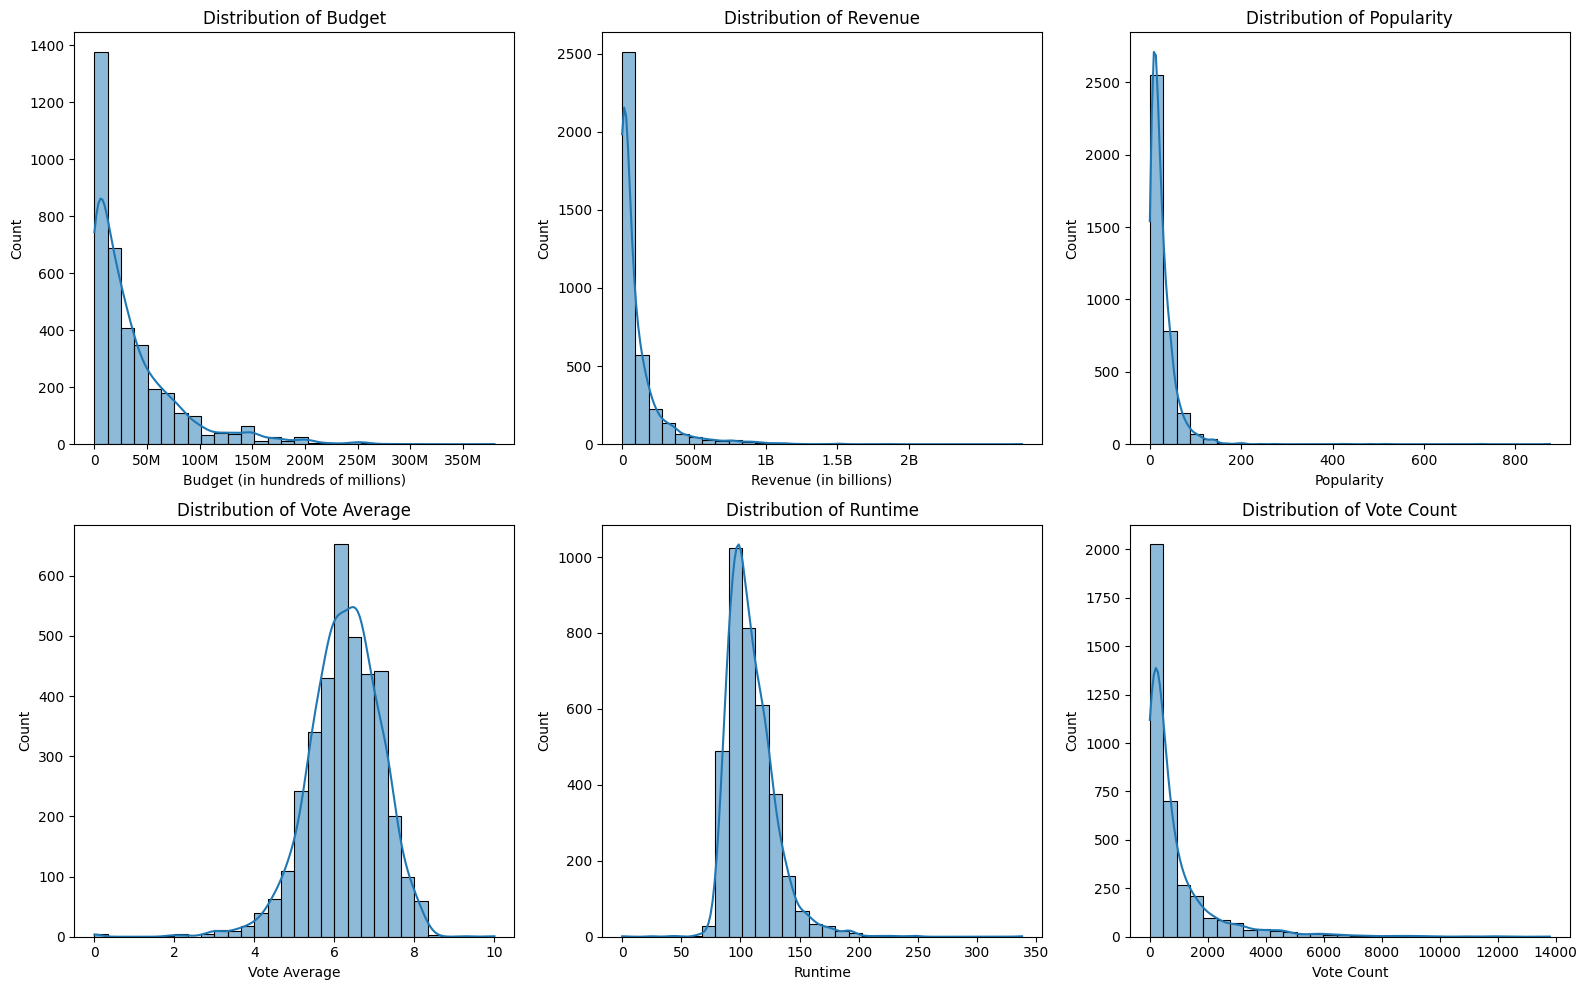

In [31]:
# Create distributions for different variables 
# Set the plot size
plt.figure(figsize=(16, 10))

# Plot the distribution of Budget with bins and formatted x-axis
plt.subplot(2, 3, 1)
sns.histplot(final_movies_df['budget'], kde=True, bins=30)
plt.title('Distribution of Budget')
plt.xlabel('Budget (in hundreds of millions)')
plt.xticks([0, 50000000, 100000000, 150000000, 200000000, 250000000, 300000000, 350000000], 
           ['0', '50M', '100M', '150M', '200M', '250M', '300M', '350M'])

# Plot the distribution of Revenue with bins and formatted x-axis
plt.subplot(2, 3, 2)
sns.histplot(final_movies_df['revenue'], kde=True, bins=30)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue (in billions)')
plt.xticks([0, 500000000, 1000000000, 1500000000, 2000000000], 
           ['0', '500M', '1B', '1.5B', '2B'])

# Plot the distribution of Popularity
plt.subplot(2, 3, 3)
sns.histplot(final_movies_df['popularity'], kde=True, bins=30)
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')

# Plot the distribution of Vote Average
plt.subplot(2, 3, 4)
sns.histplot(final_movies_df['vote_average'], kde=True, bins=30)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')

# Plot the distribution of Runtime
plt.subplot(2, 3, 5)
sns.histplot(final_movies_df['runtime'], kde=True, bins=30)
plt.title('Distribution of Runtime')
plt.xlabel('Runtime')

# Plot the distribution of Vote Count
plt.subplot(2, 3, 6)
sns.histplot(final_movies_df['vote_count'], kde=True, bins=30)
plt.title('Distribution of Vote Count')
plt.xlabel('Vote Count')

# Adjust layout and display all plots
plt.tight_layout()
plt.show()


#### Insights on "Distribution":

- Budget: The distribution is right-skewed, meaning most movies have lower budgets, with a few movies having exceptionally higher budgets.
- Revenue: Similarly, revenue is right-skewed, with some movies generating little to no revenue while a few have very high earnings.
- Popularity: This variable is also right-skewed, with most movies having relatively low popularity scores.
- Vote Average: The distribution is relatively normal, with most movies rated between 5 and 7. There is a small left tail with some outliers having lower ratings.
- Runtime: This is normally distributed, with most movies having runtimes between 90 to 120 minutes.
- Vote Count: The distribution is highly right-skewed, indicating that the majority of movies receive relatively few votes, with a few movies getting a large number of votes.

Overall, some of these features may need further transformation, such as normalization, logging to reduce the influence of outliers and make the data more manageable for models , or scaling  to avoid bias in the model due to a small number of highly popular films, overall changes could improve their suitability for machine learning, ensuring more reliable predictions and insights.


### Analyzing Movie Release Patterns

Explore the distribution of movies based on their release years, months, and days of the week. The visuals can help identify trends in movie production over time, seasonal patterns, and preferred days for releasing movies.  This helps us see trends in movie production over time.


<Figure size 1600x600 with 0 Axes>

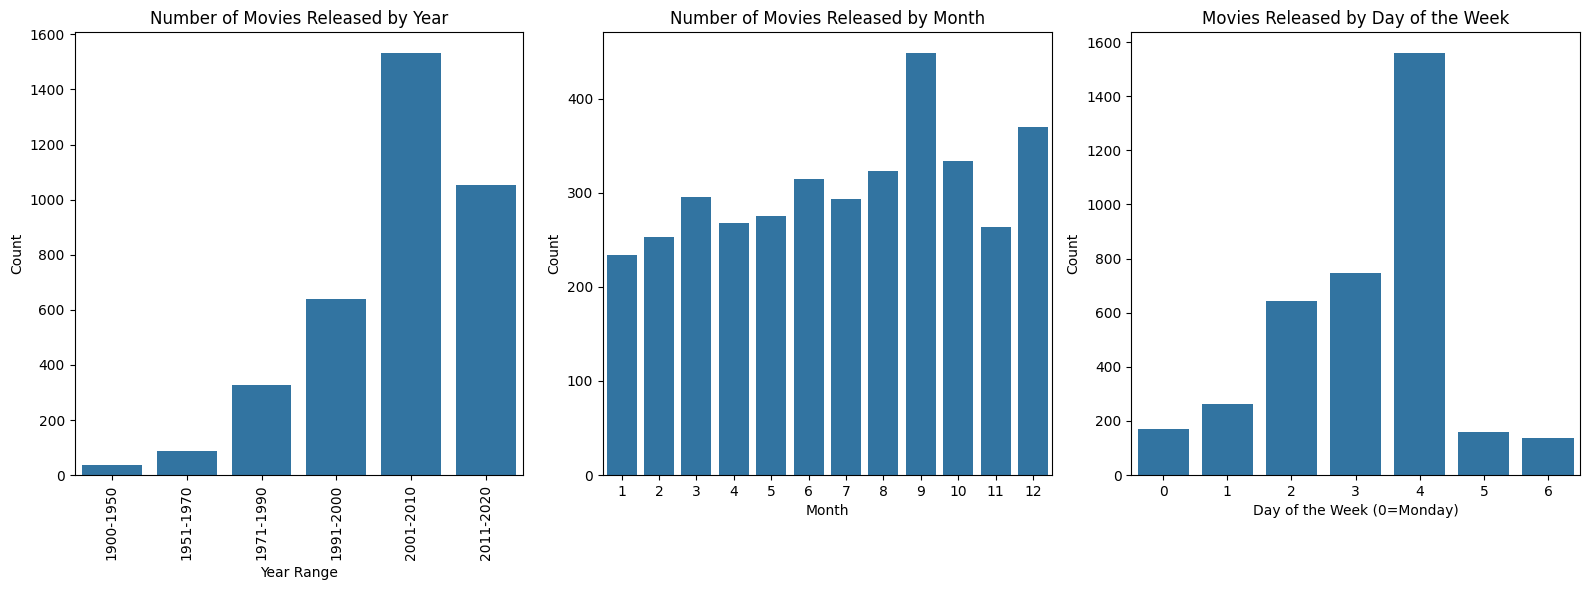

In [32]:
# Set plot size for all subplots
plt.figure(figsize=(16, 6))

# Define bins for release years 
year_bins = [1900, 1950, 1970, 1990, 2000, 2010, 2020]
year_labels = ['1900-1950', '1951-1970', '1971-1990', '1991-2000', '2001-2010', '2011-2020']
final_movies_df['release_year_bins'] = pd.cut(final_movies_df['release_year'], bins=year_bins, labels=year_labels, right=False)

# Set plot size for all subplots
plt.figure(figsize=(16, 6))

# Count of Movies Released in Each Year Bin
plt.subplot(1, 3, 1)
sns.countplot(x='release_year_bins', data=final_movies_df)
plt.xticks(rotation=90)
plt.title('Number of Movies Released by Year')
plt.xlabel('Year Range')
plt.ylabel('Count')


# Distribution of Movies Released by Month
plt.subplot(1, 3, 2)
sns.countplot(x='release_month', data=final_movies_df)
plt.title('Number of Movies Released by Month')
plt.xlabel('Month')
plt.ylabel('Count')

# Distribution of Movies Released by Day of the Week
plt.subplot(1, 3, 3)
sns.countplot(x='release_dayofweek', data=final_movies_df)
plt.title('Movies Released by Day of the Week')
plt.xlabel('Day of the Week (0=Monday)')
plt.ylabel('Count')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

#### Insights on "Patterns" :

- Yearly Trends: There has been a significant increase in the number of movies released over the decades, especially in the 2000s. This trend suggests that the film industry has become more prolific in recent years.

- Monthly Trends: Movie releases are fairly consistent throughout the year, with a slight increase during the latter months (September to December). This pattern indicates potential seasonal preferences for film releases, which could be valuable for forecasting future movie performance.

- Weekly Trends: The majority of movies are released on Fridays, reflecting industry practices that leverage weekend box office sales. Understanding these release patterns can enhance predictive models related to box office performance.

Overall, several transformations may be needed to ; normalization techniques can help manage the right-skewed distributions of features like budget and revenue, reducing the impact of outliers  , logarithmic transformations on skewed features can stabilize variance and make relationships between variables more linear ,  standardizing features such as popularity and vote count can prevent bias in model training caused by a few extremely popular films. This ensures that all features contribute equally to the model's predictions  to potentially enhance the performance of machine learning models used. 

### "Distribution" of Movie Genres

Analyze the distribution of the top 10 most common movie genres by exploding the `genres` column. Understanding the most common genres gives us insights into the types of movies that are frequently produced. It highlights the popularity of certain genres, which can help in analyzing trends in the film industry. 


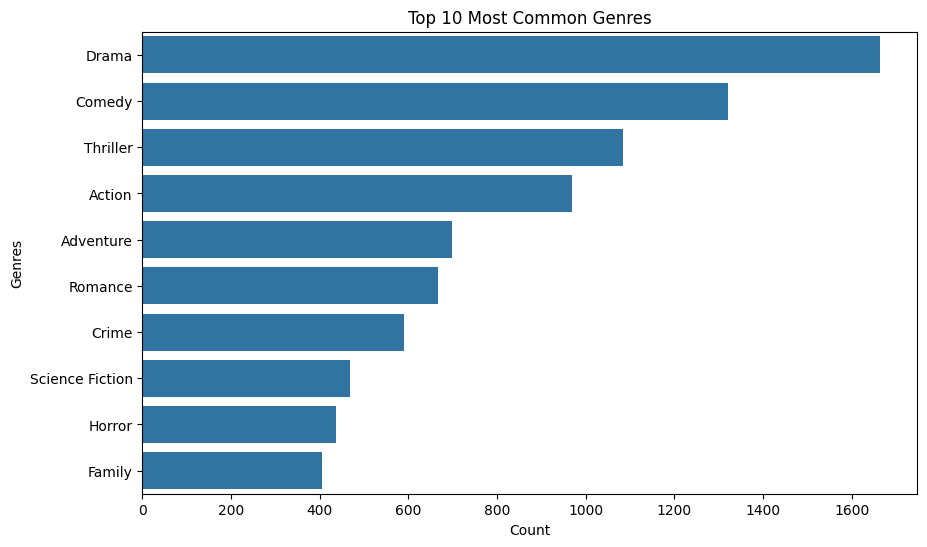

In [33]:
# Distribution of genres 
# Plot distribution of genres
plt.figure(figsize=(10, 6))

# Split genres column into multiple rows (explode) and reset index
genres_exploded = final_movies_df['genres'].str.split(', ').explode().reset_index(drop=True)

# Plot top 10 most frequent genres
sns.countplot(y=genres_exploded, order=genres_exploded.value_counts().index[:10])
plt.title('Top 10 Most Common Genres')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()


#### Insights on "Distribution of Movies" :

- Top Genres: The horizontal bar plot illustrates the ten most common movie genres, with "Drama" emerging as the most prevalent. This indicates a strong audience interest in dramatic films.

- Comparative Analysis: The varying heights of the bars enable easy comparison of genre popularity. For instance, genres like "Comedy" and "Thriller" also have substantial representation, while others are less frequent.

- Implications for Decision-Making: Understanding genre distribution may guide our machine learning models if we highlight genre as a significant feature for predicting movie success or audience ratings. 

Overall, This analysis can be crucial for stakeholders in the film industry, ensuring that productions align with audience interests and market demand. This genre analysis complements the project by reinforcing the potential value of genre in predicting movie popularity and guiding stakeholder decisions.

### Correlation and Scatter Plot Analysis

We created a correlation heatmap to identify relationships between numerical variables, such as budget and revenue. Understanding these correlations helps us spot which variables are strongly related.

Scatter plots are used to explore key relationships:
- **Budget vs Revenue**: Helps understand if higher budgets lead to higher revenues.
- **Popularity vs Revenue**: Examines if more popular movies generate more revenue.
- **Popularity vs Vote Average**: Explores the link between popularity and audience ratings.
- **Popularity vs Vote Count**: Explores the link between popularity and movie votes

These insights can inform which features to include in a machine learning model for predicting popularity.


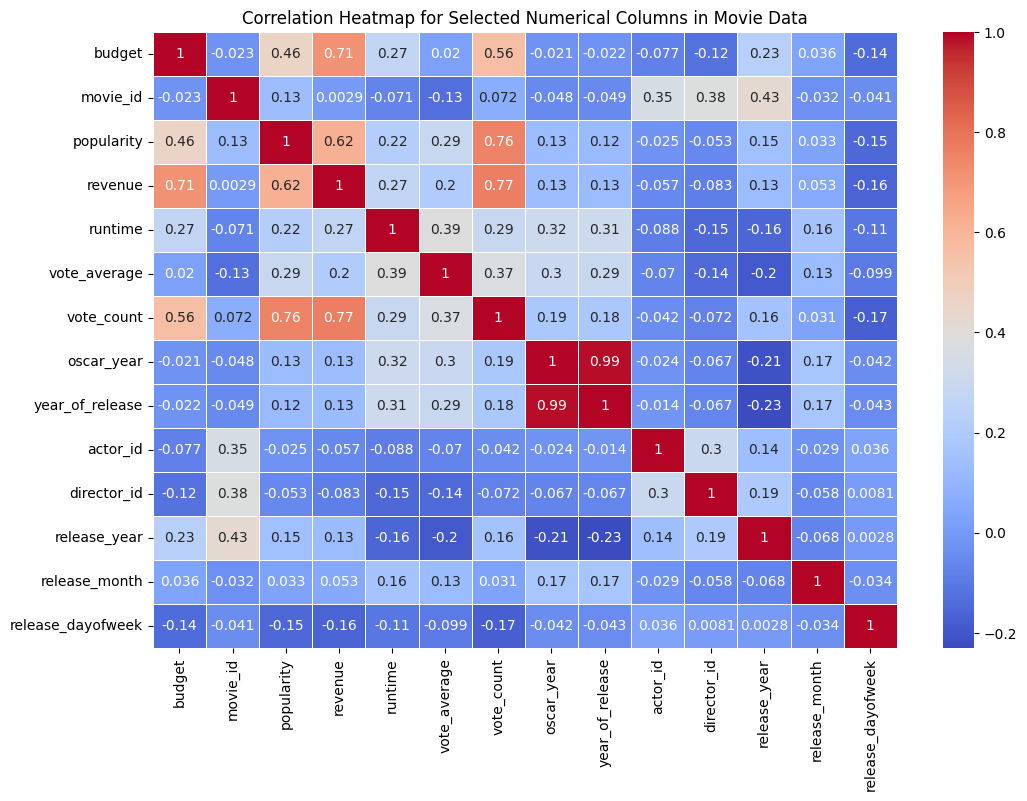

In [34]:
# Select the relevant numerical columns for the correlation matrix
numerical_columns = [
    'budget', 'movie_id', 'popularity', 'revenue', 'runtime', 
    'vote_average', 'vote_count', 'oscar_year', 'year_of_release',
    'actor_id', 'director_id', 'release_year', 'release_month', 'release_dayofweek'
]

# Calculate the correlation matrix for the selected columns
correlation_matrix = final_movies_df[numerical_columns].corr()

# Create the heatmap with the selected numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Selected Numerical Columns in Movie Data')
plt.show()

#### Insights of Correlation Heatmap:

- Strong Positive Correlations:Revenue and Budget (0.71): Higher budgets are associated with increased revenues, suggesting investment in production significantly impacts financial success. Popularity and Vote Count (0.76): Films with more votes are typically perceived as more popular, highlighting the importance of audience engagement. 

- Moderate Positive Correlations:Popularity and Revenue (0.62): Indicates that higher popularity scores often correlate with higher revenues, emphasizing the need for effective marketing strategies. Runtime and Vote Average (0.39): Suggests longer movies may receive higher ratings, though this relationship is weaker.

- Weak or Negative Correlations:Budget and Vote Average (-0.02): Shows no significant relationship, indicating that a larger budget doesn't guarantee better ratings. Oscar Year and Revenue (0.19): A weak positive correlation suggests that Oscar wins may influence revenue but are not a primary factor.

- Modeling Considerations: The identified correlations can help prioritize features for Linear Regression and Random Forest models. Features like budget, revenue, and vote count should be emphasized for better accuracy. 

- Future Engineering: Normalization or transformation of features such as budget and revenue may be necessary to reduce outlier impact and ensure a balanced dataset. 

Overall, these insights help guide the project toward recognizing key factors influencing movie popularity, ultimately aligned with supporting stakeholders in estimating a film's success.

### Relationships and Scatter Plot Analysis

We created scatter plots to explore key relationships among numerical variables in our movie dataset.

- **Budget vs Revenue**: This plot helps assess whether higher budgets correlate with increased revenues, indicating the financial viability of investment in production.

- **Popularity vs Revenue**: It examines the relationship between a movie's popularity score and its generated revenue, helping to determine if a popular film translates into higher earnings.

- **Popularity vs Vote Average**: This scatter plot explores how a movie's popularity relates to its audience ratings, offering insights into audience perception and potential success.

- **Popularity vs Vote Count**: This plot investigates the connection between a film's popularity and the number of votes it receives, revealing trends in audience engagement.

These visualizations provide valuable insights that can guide feature selection for our predictive models focused on estimating a movie's popularity and success.

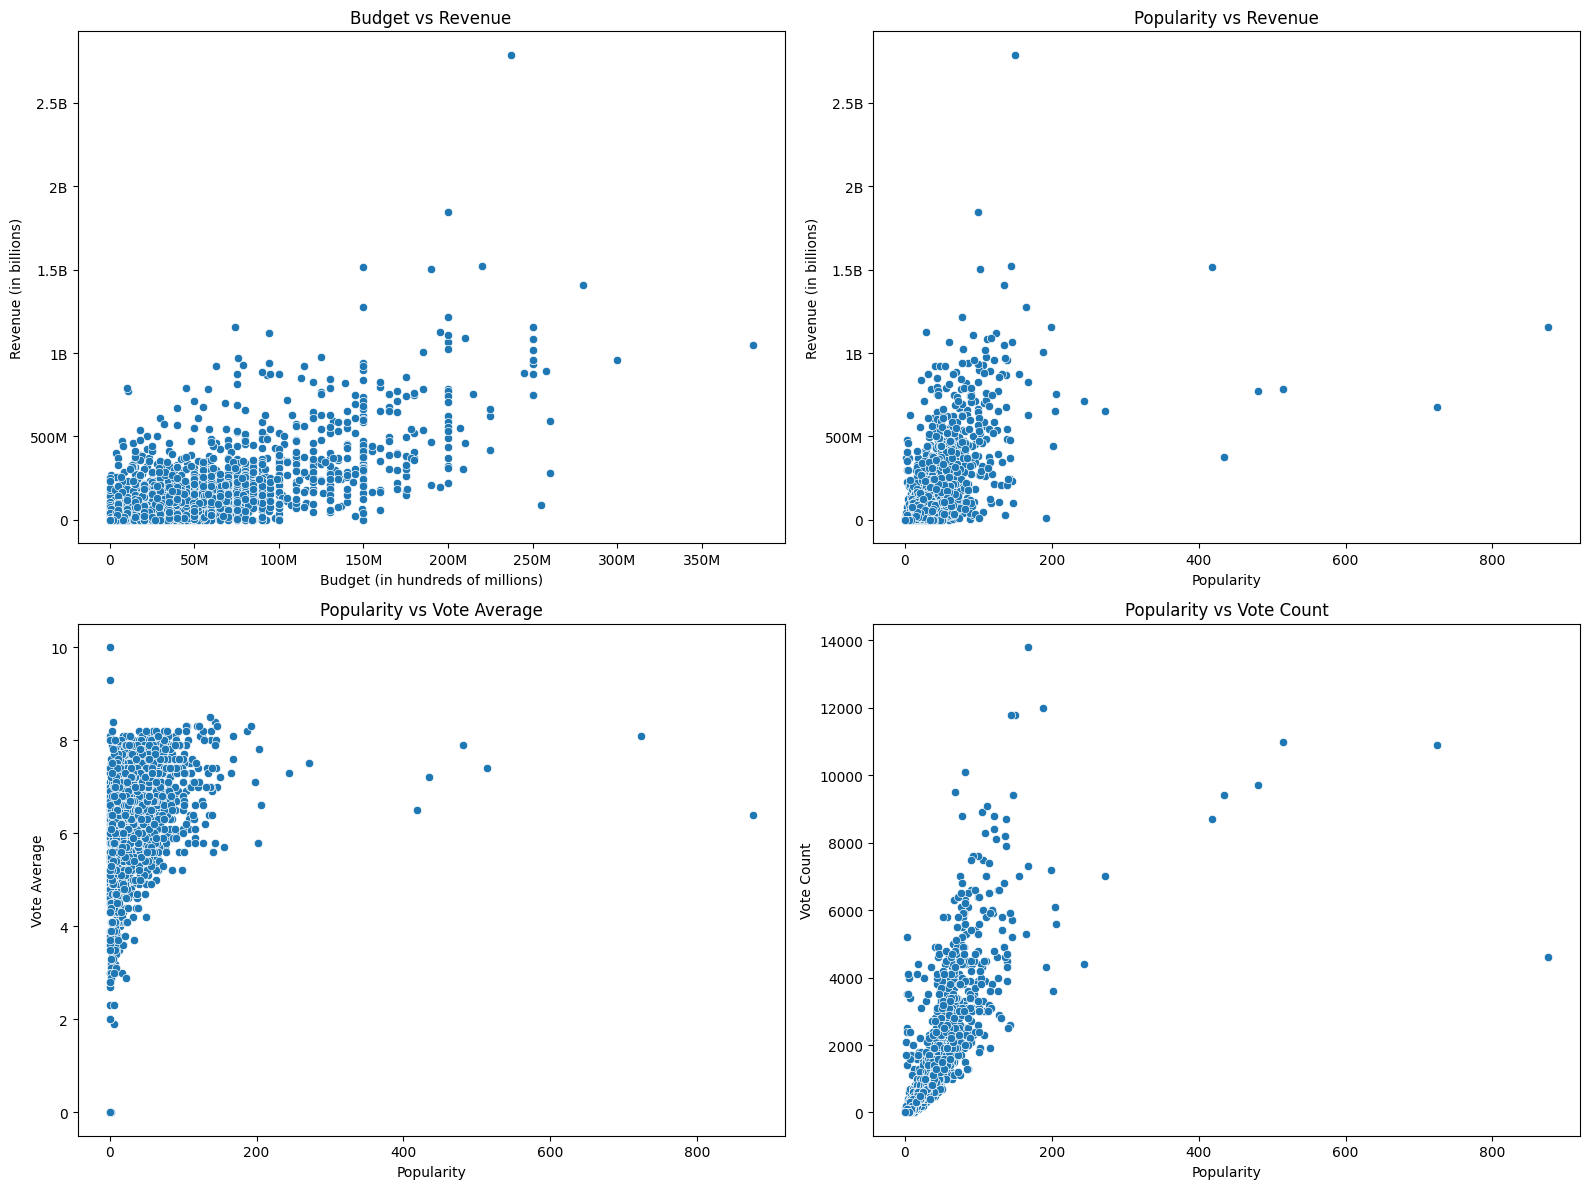

In [35]:
# Create scatter plots to explore various relationships 
# Set the plot size
plt.figure(figsize=(16, 12))

# Scatter plot for Budget vs Revenue
plt.subplot(2, 2, 1)
sns.scatterplot(x='budget', y='revenue', data=final_movies_df)
plt.title('Budget vs Revenue')
plt.xlabel('Budget (in hundreds of millions)')
plt.ylabel('Revenue (in billions)')
plt.xticks([0, 50000000, 100000000, 150000000, 200000000, 250000000, 300000000, 350000000], 
           ['0', '50M', '100M', '150M', '200M', '250M', '300M', '350M'])
plt.yticks([0, 500000000, 1000000000, 1500000000, 2000000000, 2500000000], 
           ['0', '500M', '1B', '1.5B', '2B', '2.5B'])

# Scatter plot for Popularity vs Revenue
plt.subplot(2, 2, 2)
sns.scatterplot(x='popularity', y='revenue', data=final_movies_df)
plt.title('Popularity vs Revenue')
plt.xlabel('Popularity')
plt.ylabel('Revenue (in billions)')
plt.yticks([0, 500000000, 1000000000, 1500000000, 2000000000, 2500000000], 
           ['0', '500M', '1B', '1.5B', '2B', '2.5B'])

# Scatter Plot for Popularity vs Vote Average
plt.subplot(2, 2, 3)
sns.scatterplot(x='popularity', y='vote_average', data=final_movies_df)
plt.title('Popularity vs Vote Average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')

# Scatter Plot for Popularity vs Vote Count
plt.subplot(2, 2, 4)
sns.scatterplot(x='popularity', y='vote_count', data=final_movies_df)
plt.title('Popularity vs Vote Count')
plt.xlabel('Popularity')
plt.ylabel('Vote Count')

plt.tight_layout()
plt.show()


#### Insights of "Relationships and Scatter Plot Analysis":

- Budget vs Revenue:This scatter plot illustrates a positive correlation between budget and revenue, suggesting that movies with larger budgets tend to generate higher revenues. However, this relationship may not be linear, as some high-budget films underperform at the box office. This insight highlights the importance of strategic investment in production and marketing.

- Popularity vs Revenue:The relationship between popularity and revenue indicates that more popular films often achieve higher earnings. This correlation emphasizes the need for effective marketing and audience engagement strategies to boost a film’s visibility and subsequent revenue generation.

- Popularity vs Vote Average: Analyzing the link between popularity and vote average reveals that movies that are well-received by audiences (higher vote averages) tend to be more popular. This finding suggests that positive critical reception can drive popularity, underscoring the importance of quality content in filmmaking.

- Popularity vs Vote Count:The scatter plot examining the relationship between popularity and vote count shows that movies with higher popularity often receive more votes. This correlation implies that engaging content encourages audience participation, and hence, producers should aim for narratives that resonate with viewers to drive both popularity and engagement.

Overall, budget, popularity, revenue, vote average, and vote count all show varying degrees of correlation, with budget and popularity having a stronger influence on revenue and vote counts.

### Varied Coorelation Analysis

 - We created box plots to analyze the distribution of vote averages across the top ten most common genres. This visualization helps us understand how audience ratings differ by genre, revealing patterns that may indicate genre preferences.

- We then generated a box plot to examine the relationship between revenue and award status. This visual provides insights into whether award-winning or nominated films tend to achieve higher revenues compared to their non-nominated counterparts, shedding light on the financial impact of accolades.

Vote Average by the top 10 most common Genres

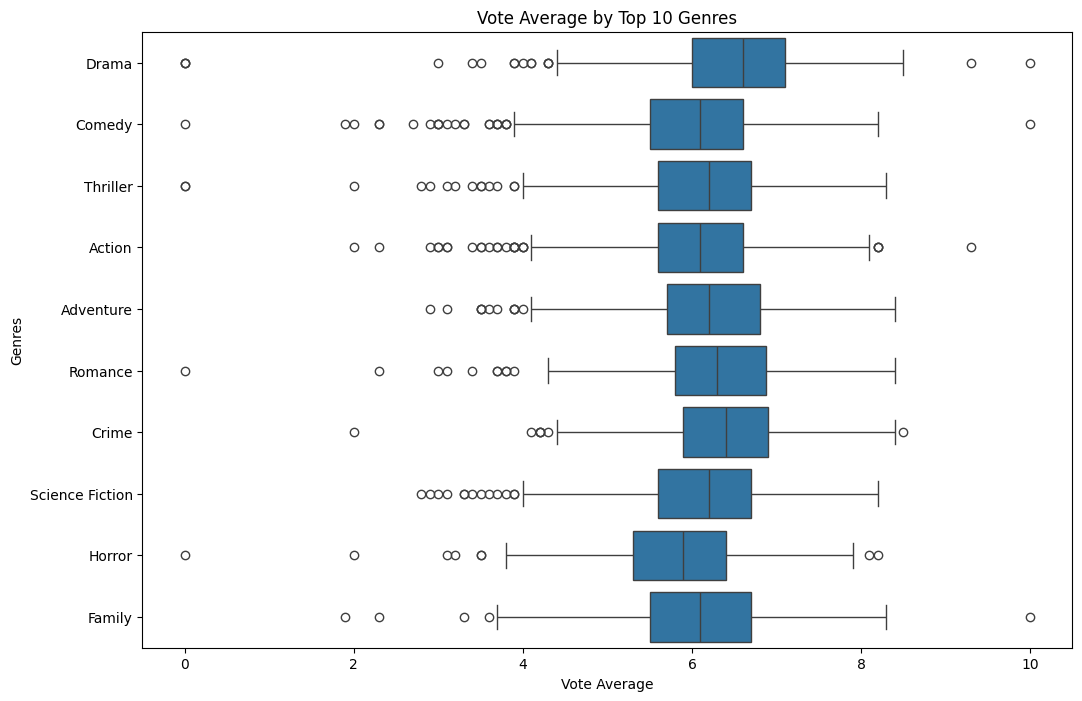

In [36]:
# Ensure genres are split by comma and exploded into individual rows
genres_exploded = final_movies_df.assign(genres=final_movies_df['genres'].str.split(', ')).explode('genres').reset_index(drop=True)

# Plot Vote Average by the top 10 most common Genres
plt.figure(figsize=(12, 8))

# Order by the most common genres and limit to top 10
top_genres = genres_exploded['genres'].value_counts().index[:10]
sns.boxplot(x='vote_average', y='genres', data=genres_exploded[genres_exploded['genres'].isin(top_genres)], order=top_genres)

plt.title('Vote Average by Top 10 Genres')
plt.xlabel('Vote Average')
plt.ylabel('Genres')
plt.show()


Correlation between Revenue and Award status

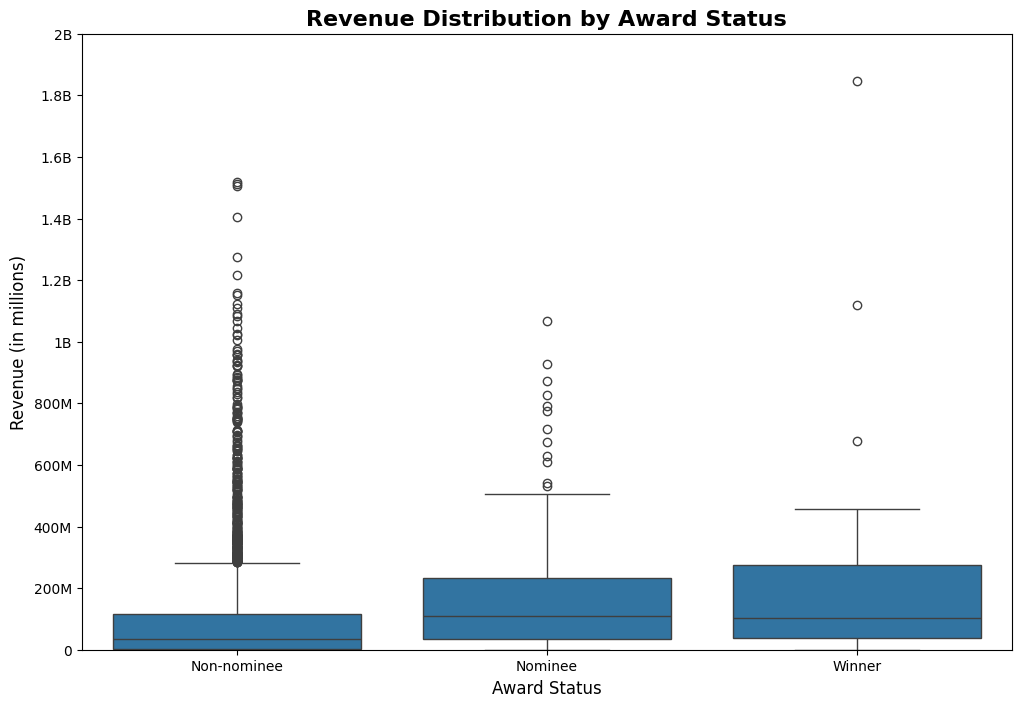

In [37]:
plt.figure(figsize=(12, 8))

# Create a boxplot of revenue by award status
sns.boxplot(x='award', y='revenue', data=final_movies_df)

# Setting labels and title
plt.title("Revenue Distribution by Award Status", fontsize=16, fontweight='bold')
plt.xlabel("Award Status", fontsize=12)
plt.ylabel("Revenue (in millions)", fontsize=12)

# Adjusting the y-axis limits and ticks for better readability
plt.ylim(0, 2e9)  # Set the upper limit to 2 billion
plt.yticks(ticks=[0, 2e8, 4e8, 6e8, 8e8, 1e9, 1.2e9, 1.4e9, 1.6e9, 1.8e9, 2e9], 
           labels=["0", "200M", "400M", "600M", "800M", "1B", "1.2B", "1.4B", "1.6B", "1.8B", "2B"])

# Display the plot
plt.show()




#### Insights for "Varied Coorelations": 

- Boxplot Insights: 
     Drama has the highest median ratings, while genres like Comedy and Action have lower medians. 
     Genres such as Science Fiction and Horror show more variability in ratings.
     Nominees and winners tend to generate more revenue than non-nominees, with nominees having some extreme outliers showing very high earnings.
 

Overall, by recognizing patterns in how genres affect audience perceptions (vote averages) and how award recognition correlates with revenue, can better understand the predictive power of certain features. This helps in building more accurate machine learning models, especially in scenarios like predicting movie success, audience engagement, or financial returns, and ensuring that the predictions reflect real-world behaviors. 

# Model Implementation 

Type of Problem: Regression - predict **movie popularity** using relevant features such as budget, runtime, genre, cast, and more.

The proceeding sections will assess: 
        * Establish a baseline metric to compare  2 ML model performance against each other .
        * Demonstrate and select (Performant model) the better of the the model results to proceed with optimization. 
        * Perform Optimization on the Performant model demonstrates strong generalization capabilities, achieving an accuracy of at least 75% or an R-squared of 0.80 on unseen data.

Machine Learning Model Descision Rationale: 
- Linear Regression offers a straightforward and interpretable approach for analyzing movie popularity based on features like budget, revenue, and awards. We considered its assumptions and limitations, such as linear relationships between variables. After evaluating the data, we determined that Linear Regression was appropriate because it provides clear insights into direct impacts on popularity.
- Random Forest captures more complex interactions and non-linear patterns between features. This model allowed us to understand how factors like genre, awards, and budget work together to influence popularity in ways that Linear Regression might miss.

## Data Preparation For Modeling 
- **Feature Selection**: Dropped unnecessary columns that do not contribute to predictive power.
- **Feature Engineering**: To improve the predictive power, we added interaction terms between key features to uncover relationships that might not be obvious. (**Budget × Runtime**)
- **Log Transformation**: Some feature distributions were highly skewed, as identified during the EDA. To address this, we applied log transformations to normalize the distribution of these features, ensuring better performance in the linear model.

In [38]:
# Dropping unnecessary columns
regression_df = final_movies_df.drop(columns=['movie_id', 'status', 'language', 'release_date','tagline', 'keywords', 'production', 'release_year_bins', 'movie_title'])
regression_df.head(5)


,budget,popularity,revenue,runtime,vote_average,vote_count,full_original_name,country_short,country_name,release_date_season,...,year_of_release,award,actor_id,actor,director_id,director_name,genres,release_year,release_month,release_dayofweek
0,4000000.0,22.9,4300000.0,98,6.5,500,English,US,United States of America,Winter,...,0,Non-nominee,3129,Tim Roth,3110,Allison Anders,"Crime, Comedy",1995,12,5
1,11000000.0,126.4,775398007.0,121,8.1,6600,English,US,United States of America,Spring,...,1977,Nominee,2,Mark Hamill,1,George Lucas,"Adventure, Action, Science Fiction",1977,5,2
2,94000000.0,85.7,940335536.0,100,7.6,6100,English,US,United States of America,Spring,...,0,Non-nominee,13,Albert Brooks,7,Andrew Stanton,"Animation, Family",2003,5,4
3,55000000.0,138.1,677945399.0,142,8.2,7900,English,US,United States of America,Summer,...,1994,Winner,31,Tom Hanks,24,Robert Zemeckis,"Comedy, Drama, Romance",1994,7,2
4,15000000.0,80.9,356296601.0,122,7.9,3300,English,US,United States of America,Fall,...,1999,Winner,1979,Kevin Spacey,39,Sam Mendes,Drama,1999,9,2


In [39]:
# Check for any null values 
null_df = regression_df.isnull().sum()
print(null_df)

budget                 0
popularity             0
revenue                0
runtime                0
vote_average           0
vote_count             0
full_original_name     0
country_short          0
country_name           0
release_date_season    0
oscar_year             0
year_of_release        0
award                  0
actor_id               0
actor                  0
director_id            0
director_name          0
genres                 0
release_year           0
release_month          0
release_dayofweek      0
dtype: int64


In [40]:
# Feature Engineering: Adding interaction terms (budget * runtime, etc.)
regression_df['budget_runtime_interaction'] = regression_df['budget'] * regression_df['runtime']

In [41]:
# Specify the columns you want to describe
columns_to_describe = ['budget', 'revenue', 'popularity']

# Apply .describe() on these columns
regression_df[columns_to_describe].describe()

,budget,revenue,popularity
count,3.672000e+03,3.672000e+03,3672.000000
mean,3.547701e+07,1.037963e+08,26.308361
std,4.323579e+07,1.785696e+08,34.609729
min,0.000000e+00,0.000000e+00,0.000000
25%,5.000000e+06,4.140469e+06,8.500000
50%,2.000000e+07,3.839126e+07,17.800000
75%,5.000000e+07,1.224956e+08,33.900000
max,3.800000e+08,2.787965e+09,875.600000


In [42]:
# Apply log transformation to revenue, budget, and popularity to normalize their distribution
regression_df['revenue_log'] = np.log1p(regression_df['revenue'])
regression_df['budget_log'] = np.log1p(regression_df['budget']) 
regression_df['popularity_log'] = np.log1p(regression_df['popularity'])

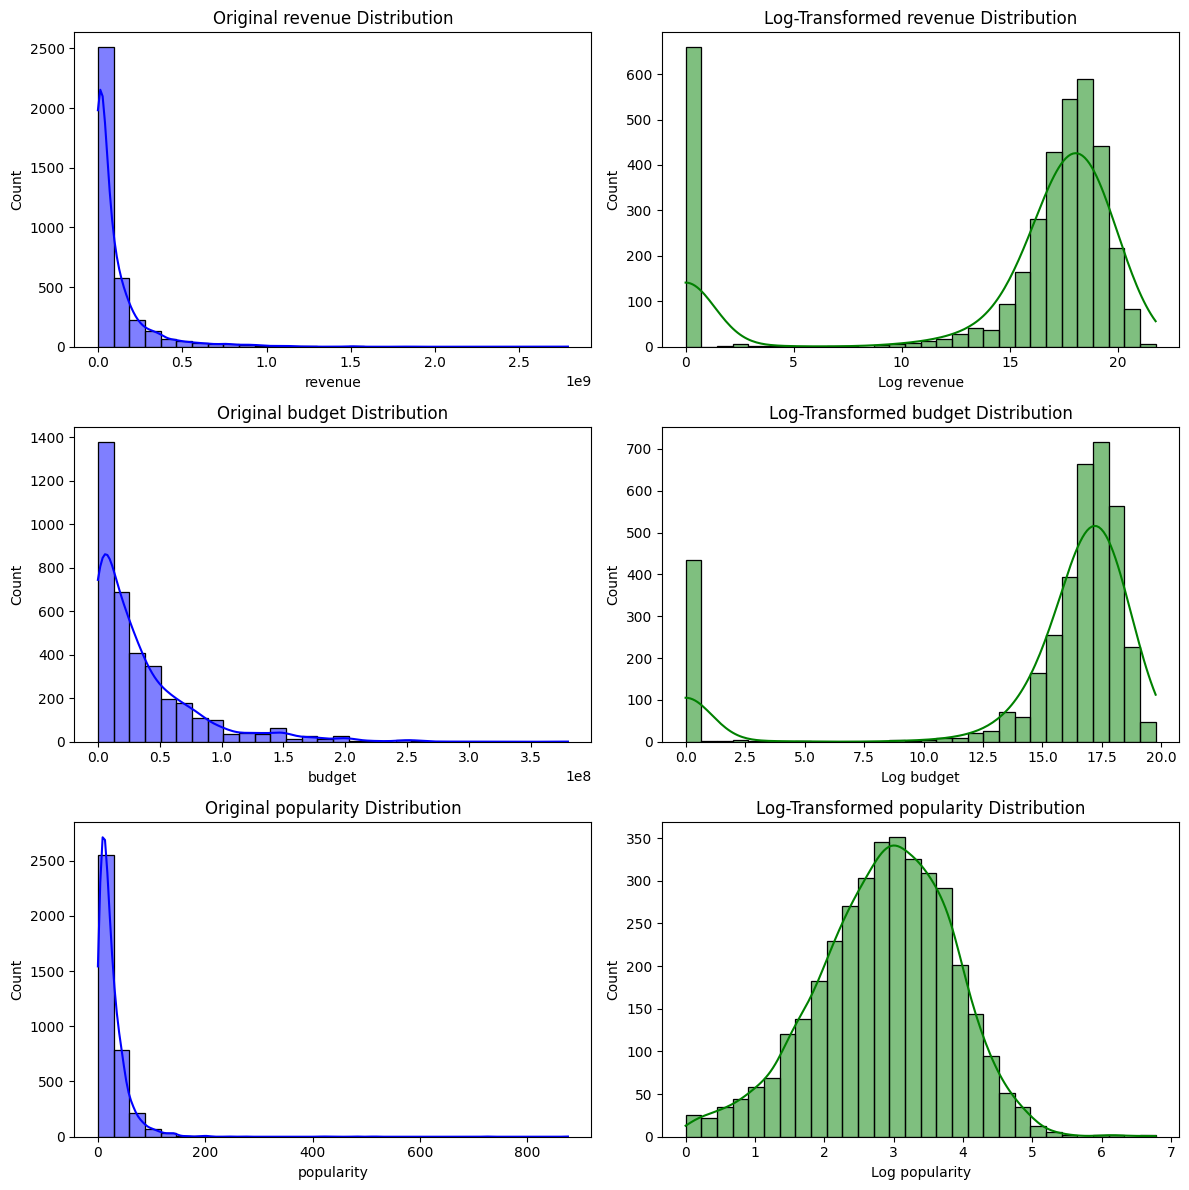

In [43]:
# Columns to visualize
columns = ['revenue', 'budget', 'popularity']

# Set up the plot
plt.figure(figsize=(12, 12))

# Loop through the columns and plot original and log-transformed data
for i, col in enumerate(columns):
    # Plot original data
    plt.subplot(3, 2, 2*i + 1)
    sns.histplot(regression_df[col], kde=True, bins=30, color='blue')
    plt.title(f'Original {col} Distribution')
    plt.xlabel(col)
    
    # Plot log-transformed data
    plt.subplot(3, 2, 2*i + 2)
    sns.histplot(regression_df[f'{col}_log'], kde=True, bins=30, color='green')
    plt.title(f'Log-Transformed {col} Distribution')
    plt.xlabel(f'Log {col}')

# Adjust the layout for clarity
plt.tight_layout()
plt.show()


In [44]:
# Drop the original columns that are transformed
regression_df = regression_df.drop(['revenue', 'budget', 'popularity'], axis=1)

### Label Encoding for Categorical Features

We apply **label encoding** to the categorical features **release_month** and **release_dayofweek** to convert these values into numerical format. This will allow the machine learning models to understand their distinct categories. further explain this say that its a liner scale 


In [45]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to 'release_month' and 'release_dayofweek' columns
regression_df['release_month_encoded'] = label_encoder.fit_transform(regression_df['release_month'])
regression_df['release_dayofweek_encoded'] = label_encoder.fit_transform(regression_df['release_dayofweek'])

# Step 4: Display the updated dataframe to verify the transformations
regression_df[['release_month', 'release_month_encoded', 'release_dayofweek', 'release_dayofweek_encoded']].head(5)

,release_month,release_month_encoded,release_dayofweek,release_dayofweek_encoded
0,12,11,5,5
1,5,4,2,2
2,5,4,4,4
3,7,6,2,2
4,9,8,2,2


### Cyclic Transformation of Month and Day Variables

By transforming the release month and day of the week into cyclic features using sine and cosine, we were able to capture these time-based features in a circular scale rather than a linear scale for modeling purposes. 

In [46]:
# Cyclic transformation of month
regression_df['month_sin'] = np.sin(2 * np.pi * regression_df['release_month_encoded'] / 12)
regression_df['month_cos'] = np.cos(2 * np.pi * regression_df['release_month_encoded'] / 12)

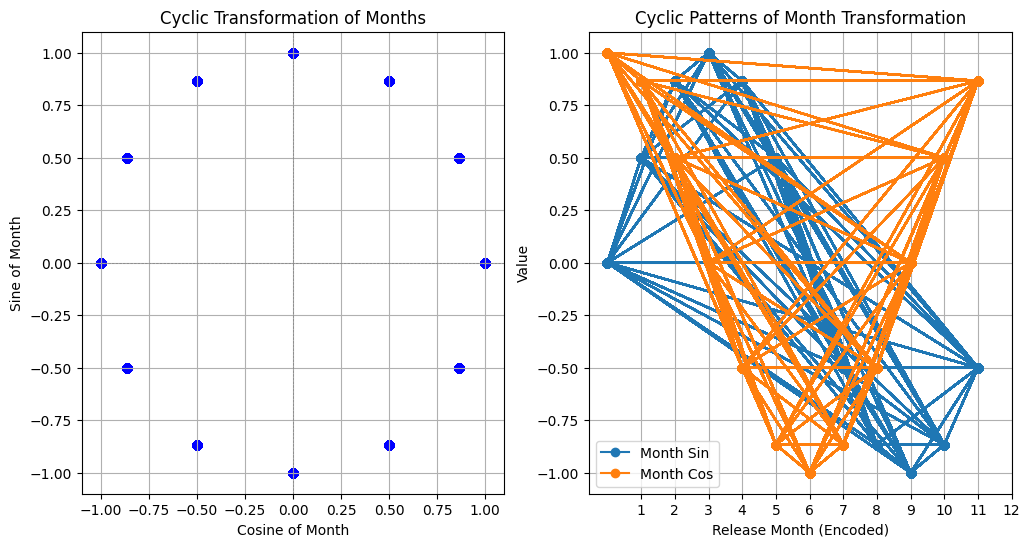

In [92]:
# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot for month_sin and month_cos
plt.subplot(1, 2, 1)
plt.scatter(regression_df['month_cos'], regression_df['month_sin'], color='b')
plt.title('Cyclic Transformation of Months')
plt.xlabel('Cosine of Month')
plt.ylabel('Sine of Month')
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--')
plt.grid()

# Line plot to show the cyclic nature
plt.subplot(1, 2, 2)
plt.plot(regression_df['release_month_encoded'], regression_df['month_sin'], label='Month Sin', marker='o')
plt.plot(regression_df['release_month_encoded'], regression_df['month_cos'], label='Month Cos', marker='o')
plt.title('Cyclic Patterns of Month Transformation')
plt.xlabel('Release Month (Encoded)')
plt.ylabel('Value')
plt.xticks(np.arange(1, 13))  # Ensure all months are labeled
plt.legend()
plt.grid()



In [47]:
# Cylic transformation of day of the week 
regression_df['day_sin'] = np.sin(2 * np.pi * regression_df['release_dayofweek_encoded'] / 31)
regression_df['day_cos'] = np.cos(2 * np.pi * regression_df['release_dayofweek_encoded'] / 31)

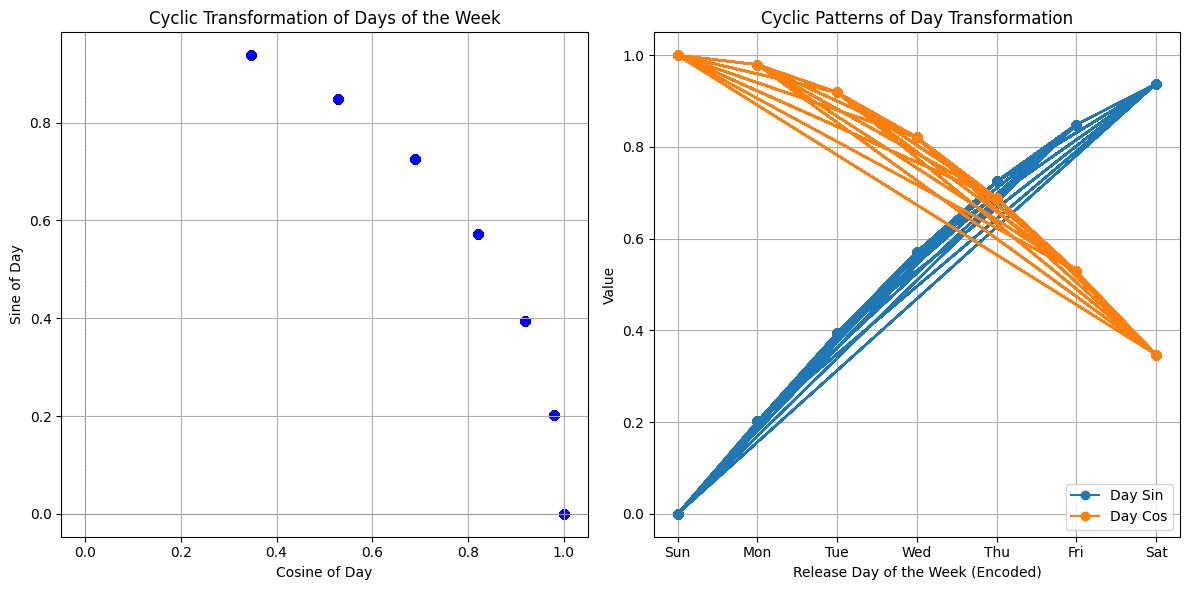

In [93]:
# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot for day_sin and day_cos
plt.subplot(1, 2, 1)
plt.scatter(regression_df['day_cos'], regression_df['day_sin'], color='b')
plt.title('Cyclic Transformation of Days of the Week')
plt.xlabel('Cosine of Day')
plt.ylabel('Sine of Day')
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--')
plt.grid()

# Line plot to show the cyclic nature
plt.subplot(1, 2, 2)
plt.plot(regression_df['release_dayofweek_encoded'], regression_df['day_sin'], label='Day Sin', marker='o')
plt.plot(regression_df['release_dayofweek_encoded'], regression_df['day_cos'], label='Day Cos', marker='o')
plt.title('Cyclic Patterns of Day Transformation')
plt.xlabel('Release Day of the Week (Encoded)')
plt.ylabel('Value')
plt.xticks(np.arange(0, 7), ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])  # Labels for days of the week
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [48]:
# Drop the columns release_month and 'release_dayofweek
regression_df = regression_df.drop(['release_month', 'release_dayofweek'], axis=1)

In [49]:
# Display the updated regression dataframe 
regression_df.head(5)

,runtime,vote_average,vote_count,full_original_name,country_short,country_name,release_date_season,oscar_year,year_of_release,award,...,budget_runtime_interaction,revenue_log,budget_log,popularity_log,release_month_encoded,release_dayofweek_encoded,month_sin,month_cos,day_sin,day_cos
0,98,6.5,500,English,US,United States of America,Winter,0,0,Non-nominee,...,3.920000e+08,15.274126,15.201805,3.173878,11,5,-5.000000e-01,0.866025,0.848644,0.528964
1,121,8.1,6600,English,US,United States of America,Spring,1977,1977,Nominee,...,1.331000e+09,20.468887,16.213406,4.847332,4,2,8.660254e-01,-0.500000,0.394356,0.918958
2,100,7.6,6100,English,US,United States of America,Spring,0,0,Non-nominee,...,9.400000e+09,20.661747,18.358805,4.462454,4,4,8.660254e-01,-0.500000,0.724793,0.688967
3,142,8.2,7900,English,US,United States of America,Summer,1994,1994,Winner,...,7.810000e+09,20.334577,17.822844,4.935193,6,2,1.224647e-16,-1.000000,0.394356,0.918958
4,122,7.9,3300,English,US,United States of America,Fall,1999,1999,Winner,...,1.830000e+09,19.691274,16.523561,4.405499,8,2,-8.660254e-01,-0.500000,0.394356,0.918958


## Baseline Linear Regression Model

We began by building a **Baseline Linear Regression model** to predict movie popularity using a set of relevant features.
This baseline model provides a starting point for comparison with more advanced models.

### Feature Selection for Model Traning 
Based on correlation and distribution analysis, we selected key features that have a strong relationship with movie popularity. The interaction column was selected to explore the combined effect of runtime and budget on popularity.

Some of these features demonstrated a strong relatinship with the target whereas a few did not but when handled properly with transformation, the updated features can help the model capture other patterns such as seasonal trends with months. 

In [50]:
# Selecting relevant features based on the correlation and distribution analysis
selected_features = ['budget_log', 'runtime', 'vote_average', 
                     'month_sin', 'month_cos', 'day_sin', 'day_cos',
                     'revenue_log', 'budget_runtime_interaction']

In [51]:
# Splitting data into features (X) and target (y)
X = regression_df[selected_features]
y = regression_df['popularity_log']

### Standardizing Features

To ensure that all features are on the same scale, we apply **standardization** to the relevant numerical columns to avoid no single feature dominating the model.

We did not scale the `month_sin, month_cos, day_sin` and `day_cos` because they are categorical variables, not continuous numerical features. Additionaly, `vote_average` was not scaled because it is a fixed, bounded range from 0 - 10.

`Budget_log, revenue_log, runtime` and `budget_runtime_interaction` are scaled because they have variance and are not on a comparable scales. By scaling and transformtion the features, we are able to handle entreme values (such as wide budget ranges) and treat all of the features equally in terms of their importance to predicting movie popularity. 


In [52]:
# Standardizing relevant features 
scaler = StandardScaler()
columns_to_scale = ['budget_log','revenue_log', 'runtime', 'budget_runtime_interaction']
X_scaled = X.copy()

X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

In [53]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [54]:
# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [55]:
# Make predictions on the test set
y_pred = model.predict(X_test)

### Model Evaluation: Root Mean Squared Error (RMSE) and R² Score
To evaluate our model's performance, we use two key metrics: Root Mean Squared Error (RMSE) and R-squared (R²). These metrics provide valuable insights into the accuracy and effectiveness of the model in predicting movie popularity

In [56]:
# Evaluate the model using Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the evaluation results
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

Root Mean Squared Error (RMSE): 0.6884275084348853
R-squared (R²): 0.5066330266530592


Model Insights: 
- The RMSE of 0.688 indicates the difference between the predicted movie popularity and the actual popularity. Since, the RMSE is lower, it illustrating that the model performed well, but there is room for improvement. 
- The R-squared of 0.507 means that approximately 50.7% of the variance in movie popularity is explained by the features in our model. This did capture some of the important patterns, but there's still 49% of the variance that the model does not explain.

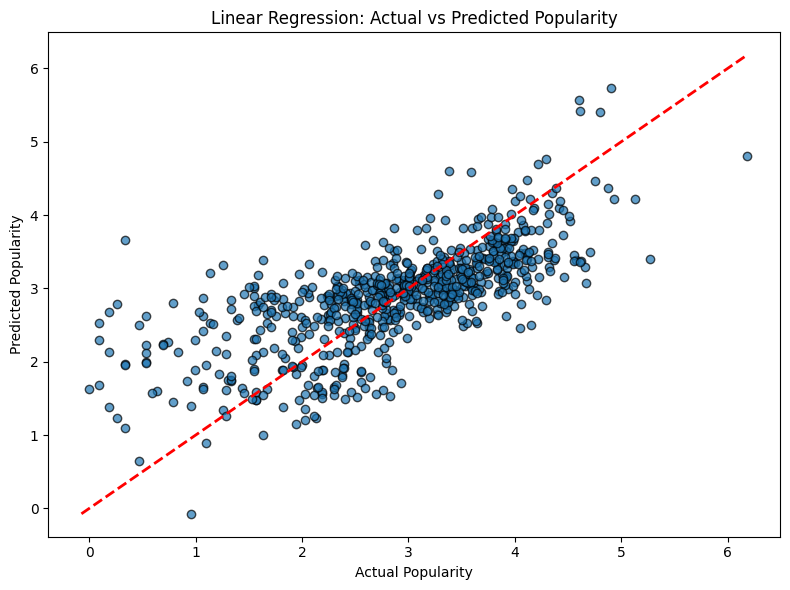

In [57]:
# Create a DataFrame with the actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['Actual'], results_df['Predicted'], edgecolor='black', alpha=0.7)

# Add the red line for perfect predictions
plt.plot([results_df.min().min(), results_df.max().max()], 
         [results_df.min().min(), results_df.max().max()], color='red', linestyle='--', lw=2)

# Add labels and title
plt.title('Linear Regression: Actual vs Predicted Popularity')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')

# Show the plot
plt.tight_layout()
plt.show()


Visual Insights:
The graph suggests that the model is a good fit for the data. However, there's always room for improvement. We could explore techniques like feature engineering, hyperparameter tuning, or trying different models to see if you can further enhance the model's performance.

C:\Users\krios\AppData\Local\Temp\ipykernel_11500\2869621080.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='cividis')


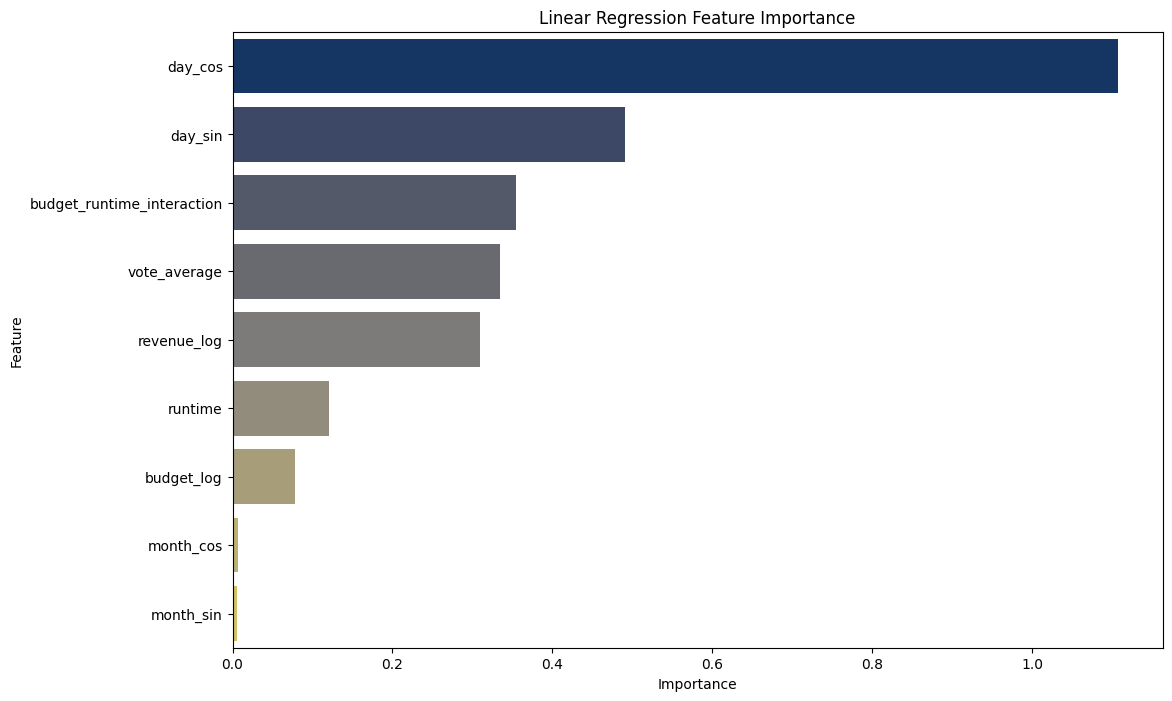

In [58]:
 # Get the coefficients from the model
coefficients = model.coef_

# Create a DataFrame for better visualization of coefficients (feature importance)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(coefficients) 
})

# Sort the features by importance (absolute value of coefficients)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='cividis')
plt.title('Linear Regression Feature Importance')
plt.show()

## Baseline Random Forest Model

After building a baseline linear regression model, we decided to implement a **Baseline Random Forest Regressor** as our second model to predict movie popularity. This model provides a more flexible approach and serves as a foundation for future optimizations and comparisons.


 Random Forest Data: For consistency and comparison, we will use the same preprocessed data that was prepared for the baseline linear regression model. We can directly compare the performance of the Random Forest Regressor against the Linear Regression model.


In [59]:
# Copy the original machine learning dataframe
forest_df = regression_df.copy()
forest_df.head(5)

,runtime,vote_average,vote_count,full_original_name,country_short,country_name,release_date_season,oscar_year,year_of_release,award,...,budget_runtime_interaction,revenue_log,budget_log,popularity_log,release_month_encoded,release_dayofweek_encoded,month_sin,month_cos,day_sin,day_cos
0,98,6.5,500,English,US,United States of America,Winter,0,0,Non-nominee,...,3.920000e+08,15.274126,15.201805,3.173878,11,5,-5.000000e-01,0.866025,0.848644,0.528964
1,121,8.1,6600,English,US,United States of America,Spring,1977,1977,Nominee,...,1.331000e+09,20.468887,16.213406,4.847332,4,2,8.660254e-01,-0.500000,0.394356,0.918958
2,100,7.6,6100,English,US,United States of America,Spring,0,0,Non-nominee,...,9.400000e+09,20.661747,18.358805,4.462454,4,4,8.660254e-01,-0.500000,0.724793,0.688967
3,142,8.2,7900,English,US,United States of America,Summer,1994,1994,Winner,...,7.810000e+09,20.334577,17.822844,4.935193,6,2,1.224647e-16,-1.000000,0.394356,0.918958
4,122,7.9,3300,English,US,United States of America,Fall,1999,1999,Winner,...,1.830000e+09,19.691274,16.523561,4.405499,8,2,-8.660254e-01,-0.500000,0.394356,0.918958


In [60]:
# Selecting relevant columns
features = ['budget_log', 'runtime', 'vote_average', 
                      'month_sin', 'month_cos', 'day_sin', 'day_cos',
                     'revenue_log', 'budget_runtime_interaction']
X = forest_df[features]

# Target variable
y = forest_df['popularity_log']

In [61]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
# Initialize the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [63]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

### Model Evaluation: Root Mean Squared Error (RMSE) and R² Score

In [64]:
# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate RMSE by taking the square root of MSE
rmse = np.sqrt(mse)

# Print the performance metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-Squared (R²): {r2}')


Root Mean Squared Error (RMSE): 0.6055005301511441
R-Squared (R²): 0.6183346814644578


Random Forest Insights: 
- The RMSE of .6055 indicates that the model's predictions are relatively accurate, but it can be improved.
- The R-squared score of 61.8% indicates the percentage of variance in the movie popularity is explained by the model. The model is not capturing the underlying patterns in the data, therefore, it can be improved. 

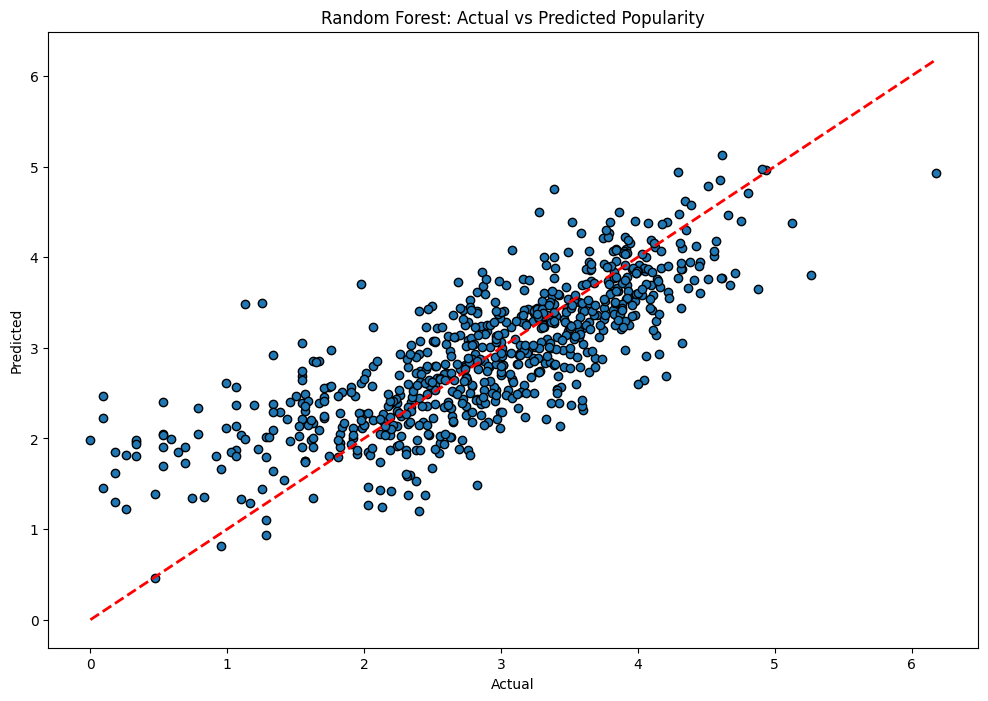

In [65]:
# Plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted Popularity')
plt.show()

Visual Insights: This appears to illustrate a better model fit, with few extreme outliers and a closer concentration of markers around the red line, suggesting lower variance in the predictions. 

### Random Forest Feature Importance

In [66]:
# Model 1: Feature Importance from rf_model
importances_1 = rf_model.feature_importances_

# Check if the lengths match
if len(features) == len(importances_1):
    # Create DataFrame for rf_model feature importance
    importance_df_1 = pd.DataFrame({
        'Feature': features,
        'Importance': importances_1
    }).sort_values(by='Importance', ascending=False)
    print("Feature Importance for rf_model:")
    print(importance_df_1)
else:
    print("Error: Features and importances in rf_model have different lengths!")

Feature Importance for rf_model:
                      Feature  Importance
7                 revenue_log    0.587276
2                vote_average    0.127534
1                     runtime    0.080307
8  budget_runtime_interaction    0.058446
0                  budget_log    0.044893
3                   month_sin    0.032753
4                   month_cos    0.031521
6                     day_cos    0.019099
5                     day_sin    0.018170


C:\Users\krios\AppData\Local\Temp\ipykernel_11500\3546982562.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_1, palette='cividis')


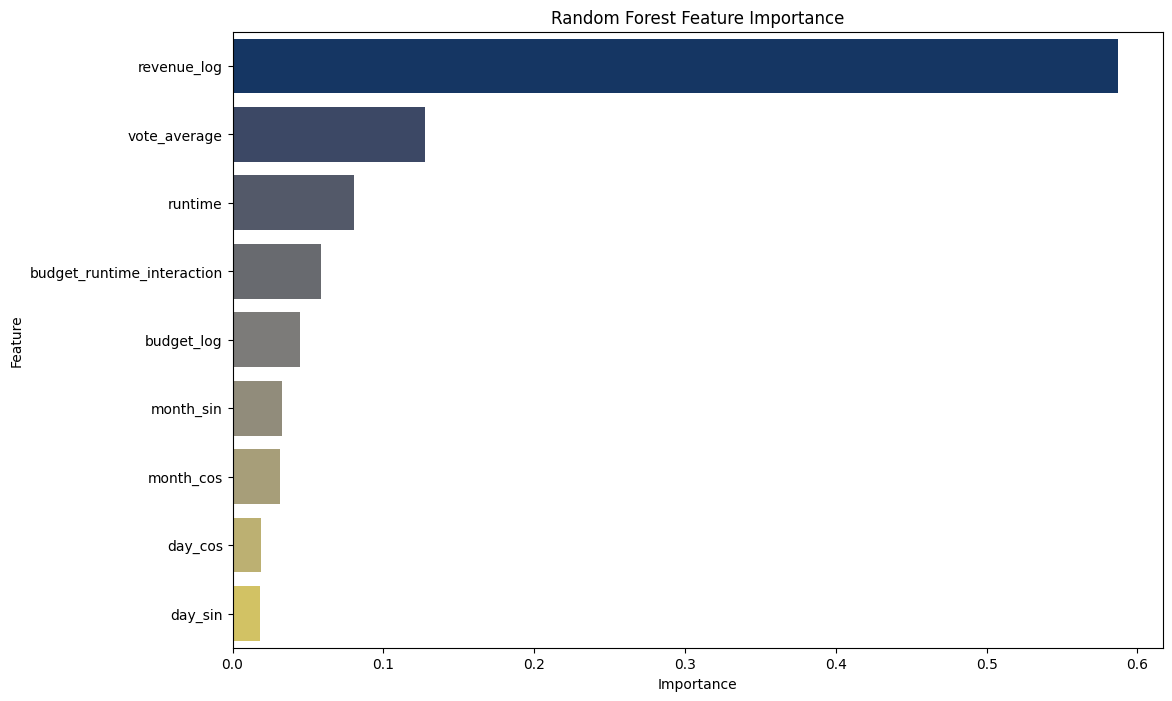

In [67]:
# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_1, palette='cividis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Optimization Process using Random Forest Machine Learning 

### Rationalization to choose Random Forest Machine Learning Model 
The group chose to optimize the Random Forest model over Linear Regression for the following key reasons:
- Complex Relationships: Random Forests capture intricate, non-linear relationships in movie data (e.g., revenue, budget) better than linear models.
- Feature Importance: They highlight which factors (e.g., genre, actor power) drive movie success, offering insights that Linear Regression may miss.
- Robustness: Random Forests handle outliers and noisy data, such as low-budget blockbusters, more effectively.
- Data Versatility: They work seamlessly with both numerical (revenue, budget) and categorical (genre, awards) data.
- Predictive Power: Random Forests generalize better to unseen data, making them ideal for predicting future movie trends.

## Optimization 1: Feature Engineering

To further improve the random forest, we decided to add more features to the model. 

- vote_count log transformation to normalize the distribution of the votes.
- vote_count_log and vot_average are useful predictors of a movie's popularity as shown above. However, adding a interaction term on both of those columns can help the model capture the combined influence of both features, showing a patterns not represented in the linear relationship.

- Adding a seasonal feature to indicate whether the movie was released during Oscar seasons--Winter/Fall. This can capture the improtance of release timing, whcih can increase movie visibility and potentially popularity. 
  

In [68]:
# Apply log transformation to vote_count
forest_df['vote_count_log'] = np.log1p(regression_df['vote_count'])  

### Visualizing Original and Log-Transformed Features

The visuaul clearly highlights the difference between the orgianl vs log-transformed vote_count column. 

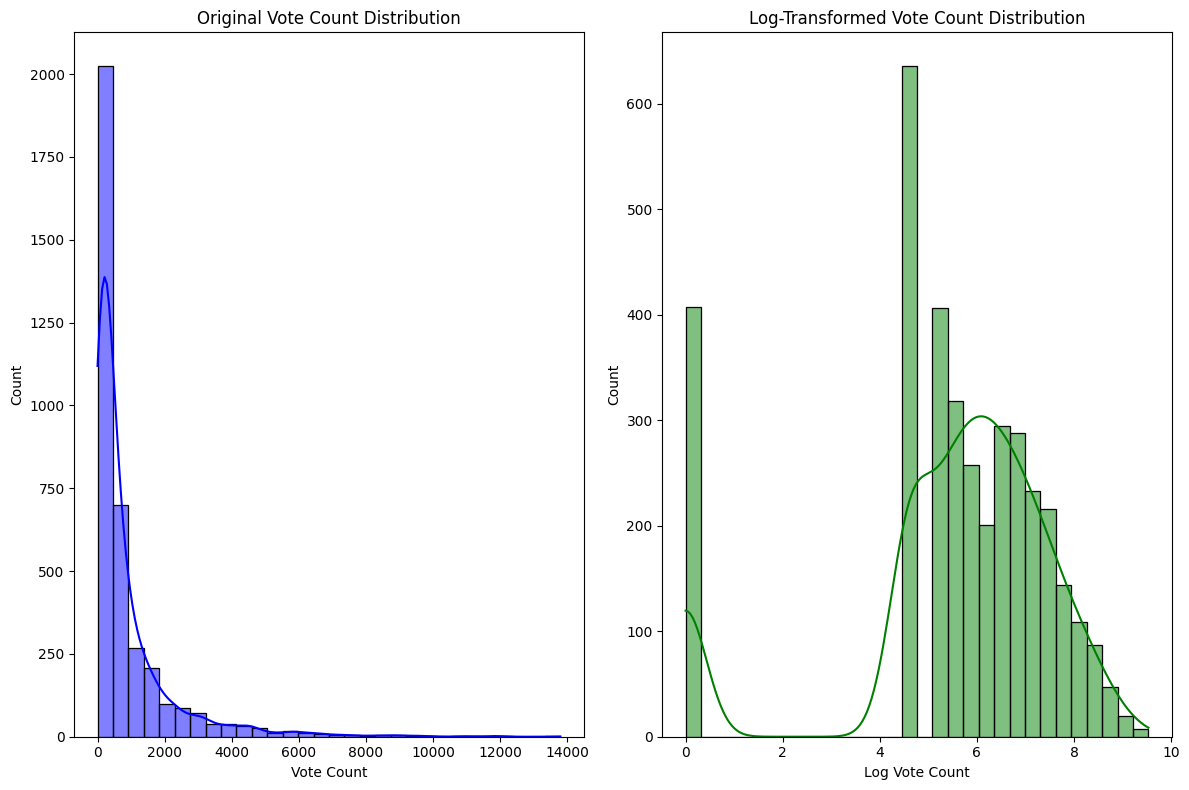

In [69]:
# Create a distribution plot for both original and log-transformed data
plt.figure(figsize=(12, 8))

# Plot original vote_count distribution
plt.subplot(1, 2, 1)
sns.histplot(forest_df['vote_count'], kde=True, bins=30, color='blue')
plt.title('Original Vote Count Distribution')
plt.xlabel('Vote Count')

# Plot log-transformed vote_count distribution
plt.subplot(1, 2, 2)
sns.histplot(forest_df['vote_count_log'], kde=True, bins=30, color='green')
plt.title('Log-Transformed Vote Count Distribution')
plt.xlabel('Log Vote Count')

# Disply plot
plt.tight_layout()
plt.show()

In [70]:
# Create interaction features using vote_count_log and vote_average 
forest_df['vote_count_avg_interaction'] = forest_df['vote_count_log'] * forest_df['vote_average']

In [71]:
# Add a seasonal feature for Oscar season (Fall/Winter releases)
forest_df['oscar_season'] = forest_df['release_date_season'].apply(lambda x: 1 if x in ['Fall', 'Winter'] else 0)

In [72]:
# Print the updated columns for the dataframe
forest_df.columns

Index(['runtime', 'vote_average', 'vote_count', 'full_original_name',
       'country_short', 'country_name', 'release_date_season', 'oscar_year',
       'year_of_release', 'award', 'actor_id', 'actor', 'director_id',
       'director_name', 'genres', 'release_year', 'budget_runtime_interaction',
       'revenue_log', 'budget_log', 'popularity_log', 'release_month_encoded',
       'release_dayofweek_encoded', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'vote_count_log', 'vote_count_avg_interaction',
       'oscar_season'],
      dtype='object')

### Feature Selection

In [73]:
# Select new relevant features
new_features = ['budget_log', 'revenue_log', 'runtime', 'vote_average', 'release_year', 
                'budget_runtime_interaction', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                'vote_count_log', 'vote_count_avg_interaction', 'oscar_season']

X_new = forest_df[new_features]

# Target variable 
y = forest_df['popularity_log']

In [74]:
# Train-test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.2, random_state=42)


In [75]:
# Initialize and train the RandomForest model
rf_model_2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_2.fit(X_train_new, y_train_new)

# Predict on the test set
y_pred_new = rf_model_2.predict(X_test_new)

### Model Evaluation: Root Mean Squared Error (RMSE) and R² Score

In [76]:
# Calculate and display performance metrics
mse_op1 = mean_squared_error(y_test_new, y_pred_new)
r2_op1 = r2_score(y_test_new, y_pred_new)

# Calculate RMSE by taking the square root of MSE
rmse_op1 = np.sqrt(mse_op1)

print(f'Root Mean Squared Error (RMSE): {rmse_op1}')
print(f'New R-Squared: {r2_op1}')

Root Mean Squared Error (RMSE): 0.3629928041279302
New R-Squared: 0.8628329893191401


Optimization Model 1 Insights:  
- The RMSE of 0.363 indicates a strong predictive performance. 
- The R-squared of 0.863 explains that 86.3% of the variance in movie popularity, capturing most of the features influencing the popularity score. 

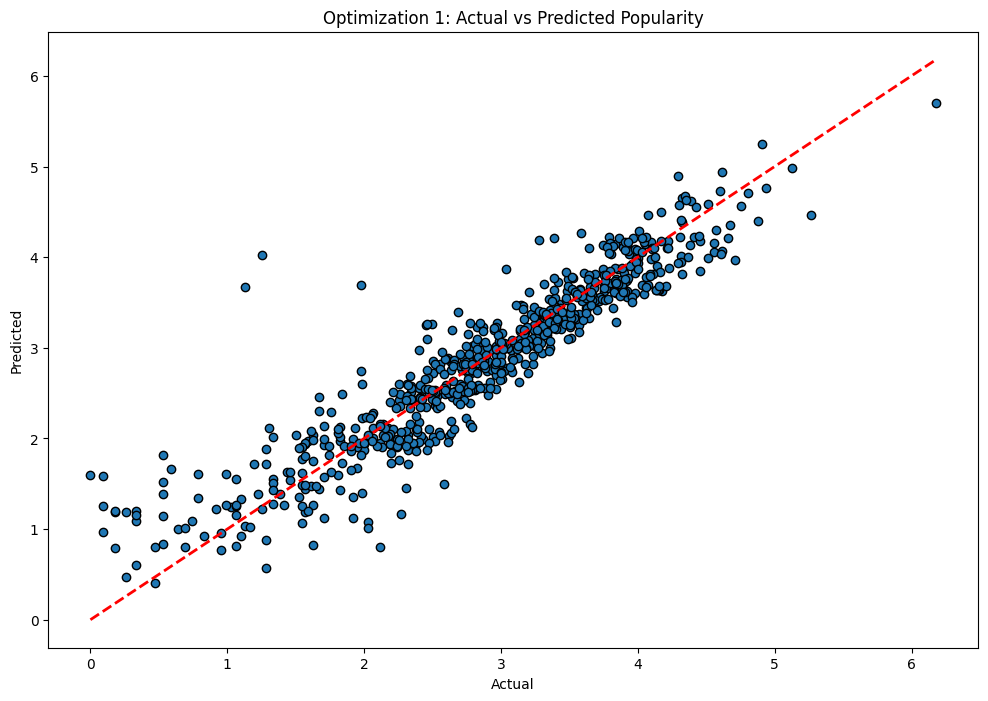

In [77]:
# Visualize Actual vs Predicted
plt.figure(figsize=(12, 8))
plt.scatter(y_test_new, y_pred_new, edgecolors=(0, 0, 0))
plt.plot([y_test_new.min(), y_test_new.max()], [y_test_new.min(), y_test_new.max()], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Optimization 1: Actual vs Predicted Popularity')
plt.show()

Optimization 1 Visual Insights: The plot shows a strong predicitve power, most markers are closely following the actual values with few outliers. 

### Random Forest Optimization 1: Feature Importance 


In [78]:
# Feature Importance from rf_model_2 (using new_features)
importances_2 = rf_model_2.feature_importances_

# Check if the lengths match
if len(new_features) == len(importances_2):
    # Create DataFrame for rf_model_2 feature importance
    importance_df_2 = pd.DataFrame({
        'Feature': new_features,
        'Importance': importances_2
    }).sort_values(by='Importance', ascending=False)
    print("\nFeature Importance for rf_model_2:")
    print(importance_df_2)
else:
    print("Error: Features and importances in rf_model_2 have different lengths!")


Feature Importance for rf_model_2:
                       Feature  Importance
10              vote_count_log    0.810490
11  vote_count_avg_interaction    0.055700
4                 release_year    0.023366
1                  revenue_log    0.020467
2                      runtime    0.019801
3                 vote_average    0.016057
5   budget_runtime_interaction    0.015685
0                   budget_log    0.010868
6                    month_sin    0.009686
7                    month_cos    0.007934
9                      day_cos    0.004474
8                      day_sin    0.004345
12                oscar_season    0.001125


C:\Users\krios\AppData\Local\Temp\ipykernel_11500\3678034592.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_2, palette='cividis')


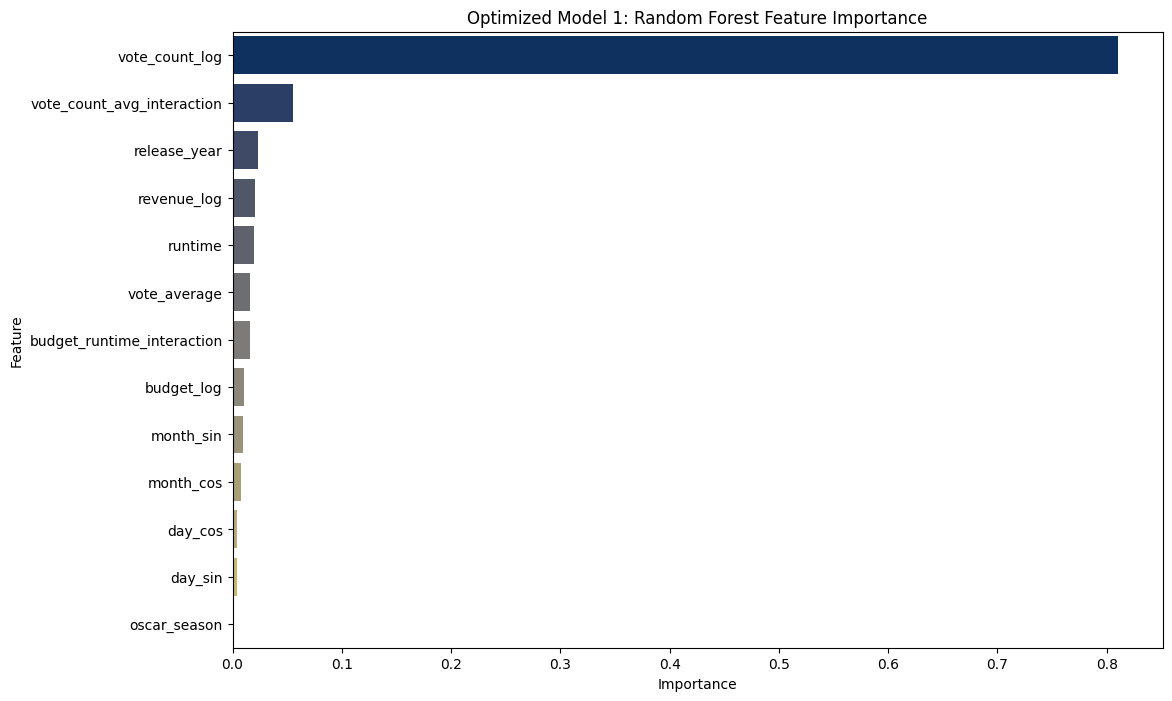

In [79]:
# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_2, palette='cividis')
plt.title('Optimized Model 1: Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Optimization 2: One-Hot Encoding on Categorical Values

Genres and awards columns represent valuable information about the type of movie and whether it has won or been nominated for a award. The box plots in the EDA show a significant influence of genres and awards on average vote which has a positive relationship with popularity. 

The group wanted to consider other non-linear factors from datasets we used. 

In [80]:
# One-hot encode the 'genres' and 'award' columns
if 'genres' in forest_df.columns and 'award' in forest_df.columns:
    forest_df = pd.get_dummies(forest_df, columns=['genres', 'award'], drop_first=True)
else:
    print("One or both of the columns 'genres' or 'award' are not present in the dataset.")


In [81]:
# Select new relevant features, including the all new one-hot encoded features
encoded_columns = [col for col in forest_df.columns if 'genres_' in col or 'award_' in col]

features_updated = ['budget_log', 'revenue_log', 'runtime', 'vote_average', 'release_year', 
                'budget_runtime_interaction', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                'vote_count_log', 'vote_count_avg_interaction', 'oscar_season'] + encoded_columns

X_updated = forest_df[features_updated]

# Target variable remains the same
y = forest_df['popularity_log']

In [82]:
# Train-test split the optimized data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_updated, y, test_size=0.2, random_state=42)

### Model Evaluation: Root Mean Squared Error (RMSE) and R² Score

In [83]:
# Initialize and train the optimized RandomForest model
rf_model_3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_3.fit(X_train_new, y_train_new)

# Predict on the test set
y_predict_best = rf_model_3.predict(X_test_new)

In [84]:
# Calculate and display performance metrics
mse_op2 = mean_squared_error(y_test_new, y_predict_best)
r2_op2 = r2_score(y_test_new, y_predict_best)

# Calculate RMSE by taking the square root of MSE
rmse_op2 = np.sqrt(mse)

# Print the performance metrics
print(f'Root Mean Squared Error (RMSE): {rmse_op2}')
print(f'R-Squared (R²): {r2_op2}')

Root Mean Squared Error (RMSE): 0.6055005301511441
R-Squared (R²): 0.8659762242238038


Optimization 2 Model Insights: 
The model is performing exceptionally well, 86.6% of the variance in movie popularity is explained. The model did slightly improve by adding the genres and award as features, but illustrated a very small influence on the predictive power. 

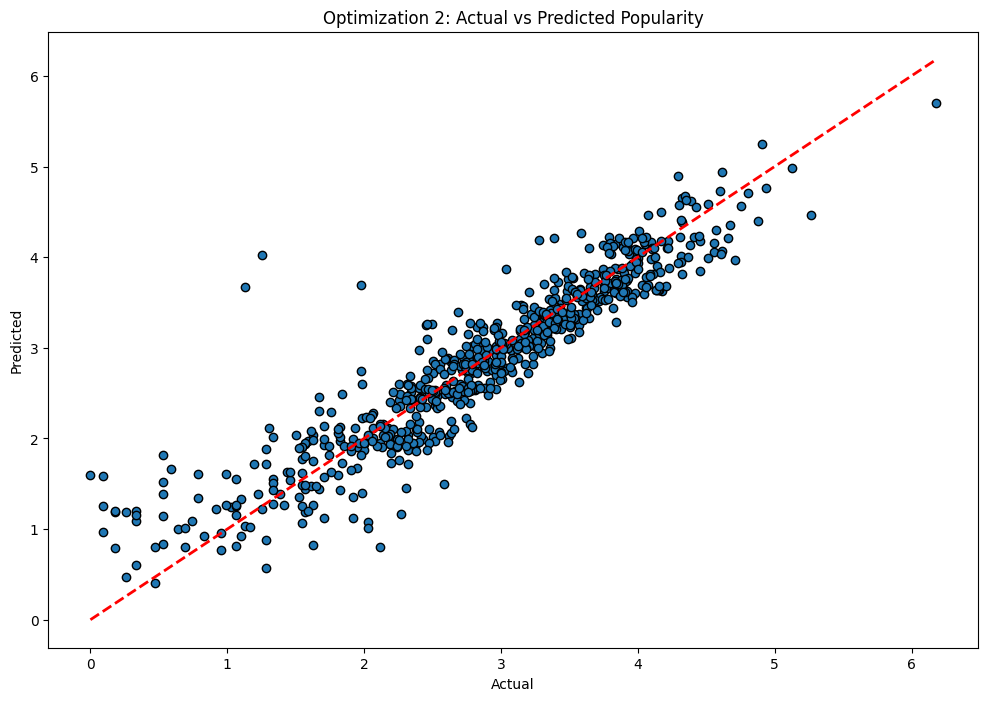

In [85]:
# Visualize Optimized Actual vs Predicted Popularity
plt.figure(figsize=(12, 8))
plt.scatter(y_test_new, y_pred_new, edgecolors=(0, 0, 0))
plt.plot([y_test_new.min(), y_test_new.max()], [y_test_new.min(), y_test_new.max()], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Optimization 2: Actual vs Predicted Popularity')
plt.show()

Optimization 2 Visual Insights: The plot shows strong predicitve power as the markers follow closely along the red line with large clusters. The model is making accurate predicitions with minor deviations but we can say that this optimized model is a reliable predicitive model for movie popularity. 

### Random Forest Optimization 2: Feature Importance

It is importance for us to see how much the new and encoded columns impacted the model. 

In [86]:
# Scenario 3: Feature Importance from rf_model_3 (using features_updated)
importances_3 = rf_model_3.feature_importances_

# Check if the lengths match
if len(features_updated) == len(importances_3):
    # Create DataFrame for rf_model_3 feature importance
    importance_df_3 = pd.DataFrame({
        'Feature': features_updated,
        'Importance': importances_3
    }).sort_values(by='Importance', ascending=False)
    print("\nFeature Importance for rf_model_3:")
    print(importance_df_3)
else:
    print("Error: Features and importances in rf_model_3 have different lengths!")



Feature Importance for rf_model_3:
                                            Feature  Importance
10                                   vote_count_log    0.809927
11                       vote_count_avg_interaction    0.047292
4                                      release_year    0.015594
2                                           runtime    0.013116
1                                       revenue_log    0.011854
..                                              ...         ...
689       genres_Family, Adventure, Science Fiction    0.000000
694                 genres_Family, Animation, Drama    0.000000
697                  genres_Family, Comedy, Fantasy    0.000000
700  genres_Family, Drama, Action, Western, Romance    0.000000
516  genres_Crime, Drama, Mystery, Thriller, Action    0.000000

[1032 rows x 2 columns]


C:\Users\krios\AppData\Local\Temp\ipykernel_11500\561171538.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_5_features, palette='cividis')


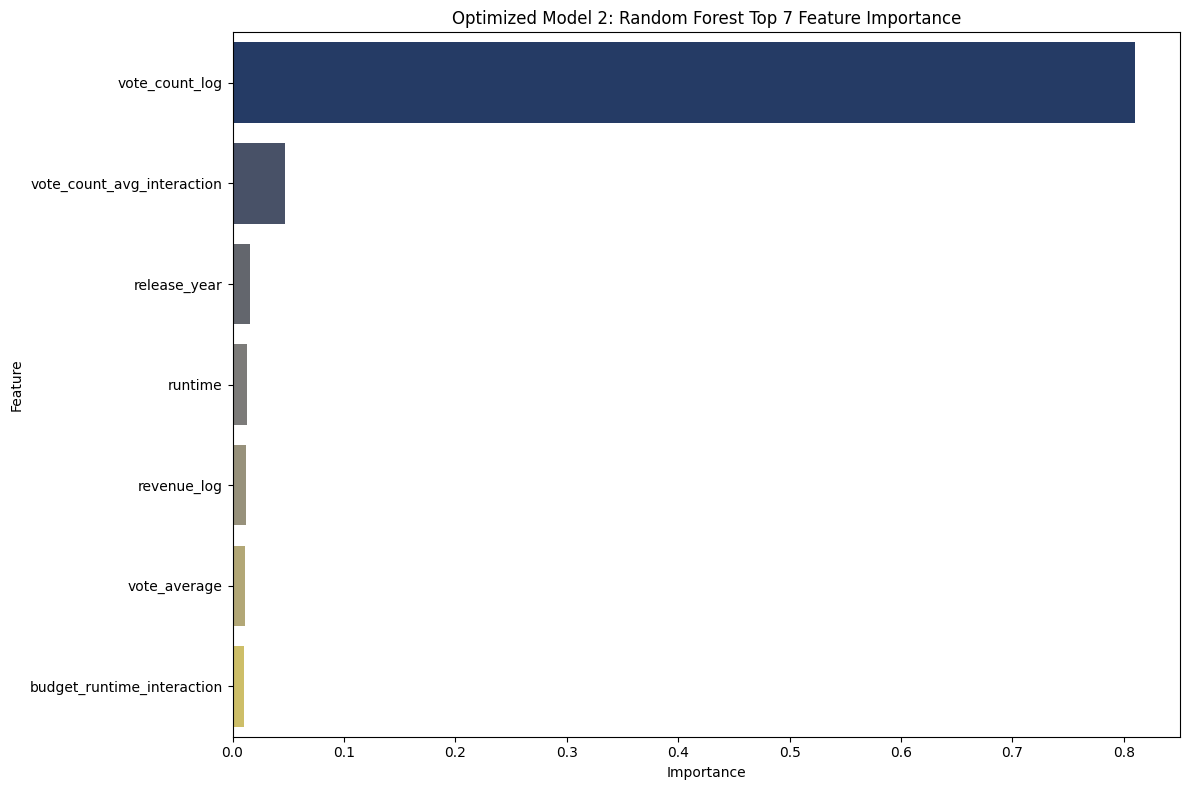

In [87]:
# Slice the top 7 features by importance
top_n = 7  
top_5_features = importance_df_3.head(top_n)

# Plot the top 7 features' importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_5_features, palette='cividis')
plt.title(f'Optimized Model 2: Random Forest Top {top_n} Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Conclusion

## Residuals Distribution 

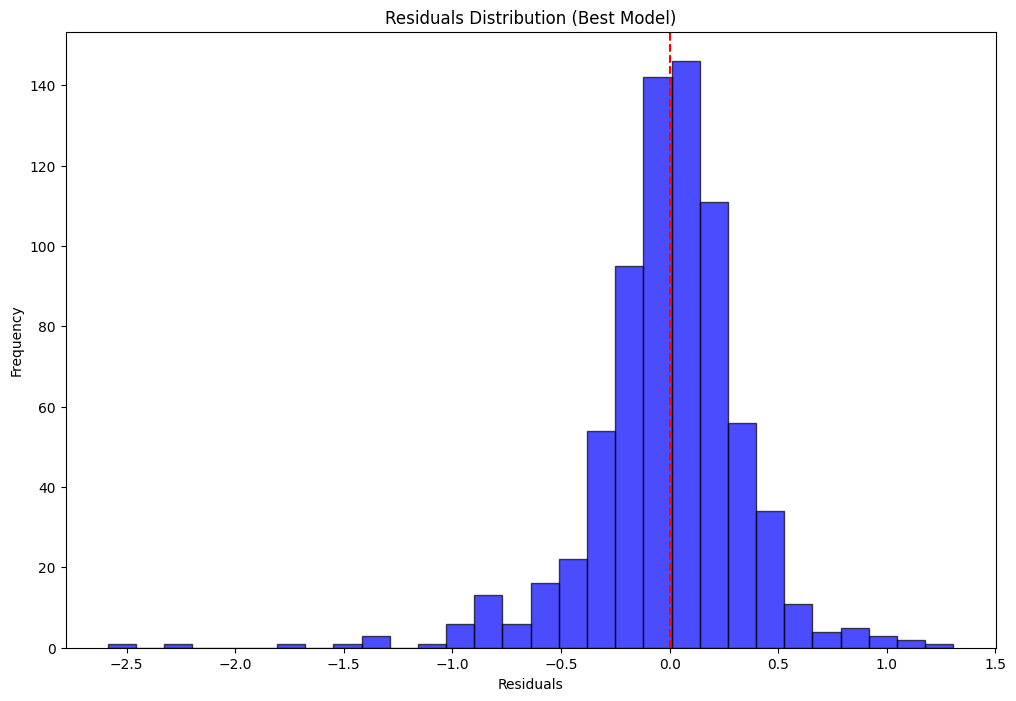

In [88]:
# Calculate residuals (errors)
residuals = y_test_new - y_predict_best

# Plot the histogram of residuals
plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')  # Reference line at 0
plt.title('Residuals Distribution (Best Model)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


## R-squared Results Based on Random Forest Optimization Techniques Line Chart

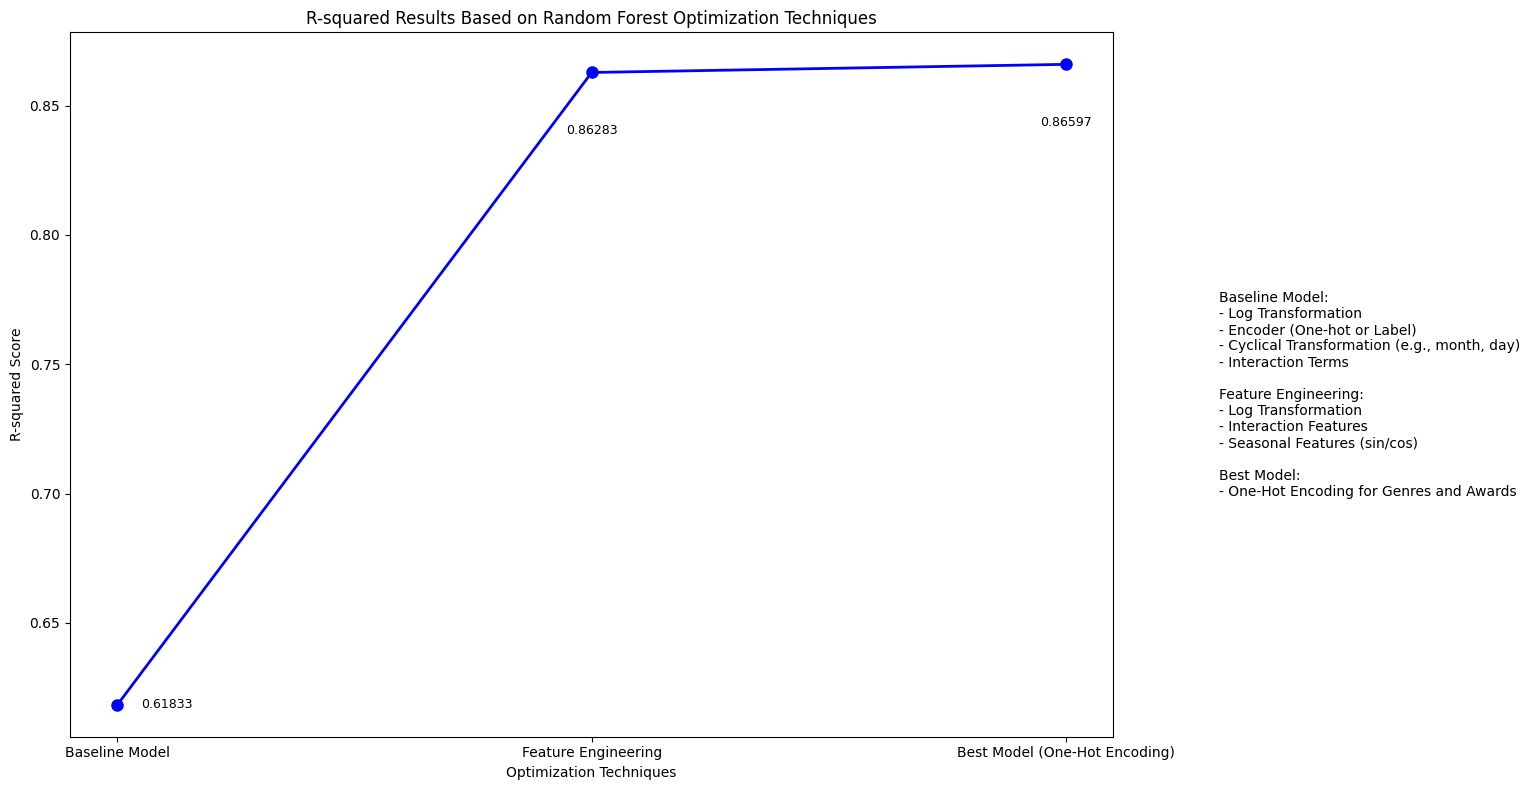

In [89]:
# R-squared results from different random forest optimization techniques
optimizations = [
    'Baseline Model', 
    'Feature Engineering',
    'Best Model (One-Hot Encoding)'
]

r_squared_scores = [0.61833, 0.86283, 0.86597]  # Adjusted with actual values from the plot

# Plot the R-squared results
plt.figure(figsize=(12, 8))
plt.plot(optimizations, r_squared_scores, marker='o', linestyle='-', color='blue', markersize=8, linewidth=2)

# Add data labels with customized positions for each marker
for i, (opt, score) in enumerate(zip(optimizations, r_squared_scores)):
    if i == 0:
        # For the first marker (Baseline), place the number to the right of the marker
        plt.text(i + 0.05, score, f'{score:.5f}', ha='left', va='center', fontsize=9)
    else:
        # For the other markers (top two), place the number slightly below the markers
        plt.text(i, score - 0.02, f'{score:.5f}', ha='center', va='top', fontsize=9)

# Enhance x-axis labels for readability
plt.title('R-squared Results Based on Random Forest Optimization Techniques')
plt.xlabel('Optimization Techniques')
plt.ylabel('R-squared Score')

# Adjust rotation to make labels more readable
plt.xticks(rotation=0, ha='center', fontsize=10)

# Add a custom legend on the side to explain the baseline model and other techniques
legend_text = (
    "Baseline Model:\n"
    "- Log Transformation\n"
    "- Encoder (One-hot or Label)\n"
    "- Cyclical Transformation (e.g., month, day)\n"
    "- Interaction Terms\n\n"
    "Feature Engineering:\n"
    "- Log Transformation\n"
    "- Interaction Features\n"
    "- Seasonal Features (sin/cos)\n\n"
    "Best Model:\n"
    "- One-Hot Encoding for Genres and Awards"
)

# Place the legend text outside the plot
plt.figtext(1.02, 0.5, legend_text, fontsize=10, verticalalignment='center')

# Adjust layout to prevent label clipping
plt.tight_layout()

# Show the plot
plt.show()

## Summary 
Objective: This project aims to develop Linear Regression and Random Forest models to predict a movie's popularity score based on features like budget, runtime, genre, and vote count. 
Our goal is to enable stakeholders in the movie industry to estimate a film's potential popularity before its release. By analyzing historical movie data, our predictive models will identify key attributes that influence success, providing producers and marketers with valuable insights.


Key Highlights:

1. Data Processing and ETL Investment:
   - We utilized JSON data to create and extract three new dataframes, consolidating various movie attributes into clean and manageable datasets for analysis.
   - A robust ETL (Extract, Transform, Load) process was applied, where we:
     - Praised JSON data and created new structured dataframes to enrich our data sources.
     - Converted raw columns such as release dates into new columns for month, day, and year to capture seasonal and temporal trends.
     - Converted data types for readability and analysis 
     - Derived and created new columns from existing ones
     - Cleaned missing data, handled outliers, and ensured consistency across the dataframes, enabling seamless integration of various features into the modeling process.
2. Exploratory Data Analysis (EDA):
   - During EDA, several key patterns were identified:
     - Budget and revenue showed strong correlations with popularity, but they were highly skewed, necessitating transformations.
     - Vote count emerged as a crucial indicator of a movie’s popularity, with higher vote counts correlating strongly with increased popularity.
     - Time-based features (like release month and day of the week) demonstrated seasonal patterns, which were incorporated into the models through cyclical feature engineering (sine/cosine transformations).
3. Feature Engineering:
   - To enhance model performance, several advanced features were created:
     - Log transformations of budget and revenue to normalize skewed data.
     - Interaction terms (e.g., between budget and runtime and between vote_count and vote_average) to capture non-linear relationships
     - Cyclical encoding for release month and release day to reflect seasonal and weekly trends in movie popularity.
     - One-hot encoding for genre and award status to capture categorical influences.
4. Model Development:
   - Two models were developed: Linear Regression and Random Forest.
   - After thorough testing, the Random Forest model significantly outperformed the linear regression model, achieving an R-squared score of 0.866, meaning it explained 86.6% of the variance in movie popularity.
   - The Root Mean Squared Error (RMSE) of 0.61 indicated that the model's predictions were highly accurate, with only minor deviations from the actual popularity values.
5. Feature Importance:
   - The most influential features in predicting movie popularity were:
     - Vote Count (log-transformed): The most significant predictor, contributing the most to the model's accuracy. Movies with a higher vote count are more likely to be popular.
     - Vote Count-Average Interaction: This feature combines vote count and average ratings, capturing the relationship between audience engagement and overall ratings.
     - Release Year: Release year also plays an important role, likely capturing historical trends in movie popularity.
     - Runtime: The length of the movie has a moderate influence on popularity.
     - Revenue (log-transformed): Revenue still plays a key role, though its influence is somewhat lessened in comparison to vote count.
6. Residual Analysis:
   - The residuals were normally distributed around zero, indicating that the model’s predictions were unbiased and balanced, with minimal error variance. This suggests that the model is reliable for predicting popularity across various types of films.